# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
# загружаем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

Прочитаем базу, выясним состав - общий объем, кол-во колонок, состав по типам данных, кол-во отсутствующих значений. Посмотрим на различные срезы данных - в начале, в конце. Оценим объем пропущенных значений и как они соотносятся с другими данными. Оценим какие данные требуют предварительной обработки и почему - изменение формата, замена пропусков, поиск возможных дубликатов.

In [2]:
# чтение файла с разделителем "табулятор" - без него 1 колонка
data_estate = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data_estate.shape

(23699, 22)

Записей 23699, 22 колонки.

In [3]:
data_estate.info()  # общая иформация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

В некоторых данных есть большого объема пропуски, что требует более детального рассмотрения. По данным "студия", "открытая планировка" - булевые значения (True, False). По данным "апартаменты" очень мало информации - чуть более 10%. Данные заполняемые автоматически, на основе картографических данных, представлены не для всех объявлений - получается системный сбой. В данных по длительности размещения объявлений есть пропуски - возможно объявление не закрыто.

Рассмотрим таблицу подробно

In [4]:
data_estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
data_estate.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.7,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.0,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.5,5.0,12.3,1,NaN,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_estate.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4656,12,3790000.0,34.0,2016-08-22T00:00:00,1,NaN,15.0,17.0,12,NaN,...,8.5,0.0,Санкт-Петербург,17284.0,16081.0,1.0,353.0,2.0,652.0,444.0
9381,10,5100000.0,64.4,2018-08-28T00:00:00,3,2.57,14.0,41.4,5,NaN,...,7.4,NaN,Санкт-Петербург,32322.0,12831.0,0.0,NaN,0.0,NaN,13.0
18327,18,6100000.0,54.5,2018-06-24T00:00:00,2,NaN,3.0,32.6,3,NaN,...,9.4,NaN,Санкт-Петербург,36270.0,9082.0,1.0,2555.0,3.0,73.0,108.0
20704,5,3850000.0,45.0,2017-10-13T00:00:00,2,NaN,5.0,32.0,4,NaN,...,7.0,NaN,Санкт-Петербург,14888.0,13428.0,0.0,NaN,1.0,512.0,124.0
16360,14,7400000.0,50.0,2018-11-23T00:00:00,1,NaN,17.0,20.0,14,NaN,...,16.0,NaN,Санкт-Петербург,17393.0,12525.0,0.0,NaN,0.0,NaN,56.0
10506,0,12000000.0,96.0,2018-02-01T00:00:00,4,3.10,5.0,68.0,1,NaN,...,12.0,NaN,Санкт-Петербург,22885.0,1782.0,2.0,485.0,2.0,639.0,126.0
16575,1,10200000.0,106.0,2015-10-14T00:00:00,3,2.70,9.0,63.1,5,NaN,...,12.1,0.0,Сестрорецк,57007.0,33936.0,2.0,347.0,2.0,144.0,359.0
17214,11,3700000.0,45.0,2015-10-31T00:00:00,2,2.50,3.0,27.6,1,NaN,...,5.0,0.0,Пушкин,15520.0,27673.0,3.0,381.0,3.0,162.0,349.0
19766,20,20000000.0,70.0,2016-05-05T00:00:00,2,3.30,5.0,34.0,3,NaN,...,26.0,0.0,Санкт-Петербург,23297.0,2308.0,3.0,442.0,1.0,81.0,191.0
21507,2,3965000.0,35.7,2018-01-15T00:00:00,1,NaN,16.0,14.0,14,NaN,...,10.0,NaN,Санкт-Петербург,30135.0,8982.0,0.0,NaN,0.0,NaN,207.0


Есть объявления без фотографий, объявления с очень высокой ценой, выше разумной на первый взгляд, по сравнению с плошадью квартиры. Данные о размещении объявления имеют время 0 часов 0 минут - вероятно система так их форматирует автоматически - нужно проверять. Некоторые объявления висели в базе по несколько лет. В названиях мест используется буква Ё ее можно заменить на привычную Е так станет меньше уникальных названий.

In [7]:
data_estate['first_day_exposition'].describe()

count                   23699
unique                   1491
top       2018-02-01T00:00:00
freq                      368
Name: first_day_exposition, dtype: object

Похоже в колонке "дата размещения объявления" все данные 0 часов 0 минут. Даже если не так - можно привести данные к формату год-месяц-день. Это не на что не повлияет.

In [8]:
data_estate['studio'].value_counts()

False    23550
True       149
Name: studio, dtype: int64

Количество студий в таблице - 149

In [9]:
data_estate['open_plan'].value_counts()

False    23632
True        67
Name: open_plan, dtype: int64

Количество квартир со свободной планировкой - 67

Проверим названия на уникальность в таблице. Могут быть записи одного и того же объекта в разном написании.

In [10]:
data_estate['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [11]:
data_estate['locality_name'].describe()

count               23650
unique                364
top       Санкт-Петербург
freq                15721
Name: locality_name, dtype: object

Как минимум один дубликат по названию есть - 'посёлок Пансионат Зелёный Бор', и 'поселок Пансионат Зелёный Бор'. Разница в написании буквы "ё". Вероятно что такого рода разночтений много в таблице (как минимум в слове "поселок"). На всякий случай нужно будет заменить "ё" на "е"

In [12]:
data_estate['locality_name'].value_counts()

Санкт-Петербург                      15721
посёлок Мурино                         522
посёлок Шушары                         440
Всеволожск                             398
Пушкин                                 369
                                     ...  
деревня Снегирёвка                       1
деревня Вахнова Кара                     1
садовое товарищество Приладожский        1
деревня Терпилицы                        1
поселок Семиозерье                       1
Name: locality_name, Length: 364, dtype: int64

In [13]:
Counter(data_estate['locality_name'])

Counter({'Санкт-Петербург': 15721,
         'посёлок Шушары': 440,
         'городской посёлок Янино-1': 61,
         'посёлок Парголово': 327,
         'посёлок Мурино': 522,
         'Ломоносов': 133,
         'Сертолово': 142,
         'Петергоф': 201,
         'Пушкин': 369,
         'деревня Кудрово': 299,
         'Коммунар': 89,
         'Колпино': 338,
         'поселок городского типа Красный Бор': 5,
         'Гатчина': 307,
         'поселок Мурино': 34,
         'деревня Фёдоровское': 8,
         'Выборг': 237,
         'Кронштадт': 96,
         'Кировск': 84,
         'деревня Новое Девяткино': 144,
         'посёлок Металлострой': 66,
         'посёлок городского типа Лебяжье': 11,
         'посёлок городского типа Сиверский': 29,
         'поселок Молодцово': 9,
         'поселок городского типа Кузьмоловский': 13,
         'садовое товарищество Новая Ропша': 1,
         'Павловск': 38,
         'деревня Пикколово': 1,
         'Всеволожск': 398,
         'Волхов': 111,


В первом приближении если и будут повторы, то в незначительном количестве.  
Проверим сколько "посёлков(поселков) Пансионат Зелёный Бор"

In [14]:
df = data_estate[(data_estate['locality_name'] ==
                  'посёлок Пансионат Зелёный Бор')]
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19681,3,1100000.0,29.1,2018-09-25T00:00:00,1,NaN,5.0,16.2,5,NaN,...,6.0,NaN,посёлок Пансионат Зелёный Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0


In [15]:
df1 = data_estate[(data_estate['locality_name'] ==
                   'поселок Пансионат Зелёный Бор')]
df1

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19981,7,1850000.0,39.0,2017-11-08T00:00:00,1,2.7,5.0,21.9,5,NaN,...,8.2,NaN,поселок Пансионат Зелёный Бор,NaN,NaN,NaN,NaN,NaN,NaN,76.0


Квартиры в Зеленом Бору это две разные квартиры.

In [16]:
# просто проверка идеи в капителью
name = "деревня петушки"
' '.join([word.capitalize() for word in name.split()])

'Деревня Петушки'

### Вывод

##### Результаты осмотра таблицы:
1. Есть большая часть данных где заполнены не все поля в объявлениях. Не факт что нужно заменять все на ноль. Часть данных можно заполнить на основе общей информации из объявления.
2. Данные по времени размещения объявления можно привести к формату "год-месяц-день" убрав нулевые значения времени. Такое изменение не повлияет на общую задачу.
3. Есть часть данных которые хорошо бы первести в целочисленный формат
    - Время размещения в днях.
    - Число парков и число водоемов.
    - Количество этажей
    - Количество балконов 
    Но из-за отсутствующих данных по этим позициям это будет проблематично делать, собственно нет особой необходимости.
5. Нужно заменить все "ё" нв "е" - правила русского языка это позволяют, заодно избавимся от дублирования названий в "locality_name"
6. Недостающие данные по расстоянию до парка в первом приближении там где парка рядом нет - то есть ближайший парк дальше чем какое то предельное значение расстояния до ближайшего парка. Тоже самое и водоемы. Скорее всего это системный сбой который в такой ситуации просто не проставляет данные.
9. Порядка 3 тыс. записей где нет информации о количестве днях размещения объявления. Вероятно объявление еще актуально и не закрыто - достаточно проверить дату размещения - если они "свежие" - гипотеза может быть верной.

### Шаг 2. Предобработка данных

Заменим данные о дате размещения, убираем часы и минуты

In [17]:
data_estate['first_day_exposition'] = pd.to_datetime(
    data_estate['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data_estate['first_day_exposition'] = data_estate['first_day_exposition'].dt.round(
    '1D')  # округлить до 1 дня
data_estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Проверим все нулевые значения и посмотрим что из них можно заменить на 0

In [18]:
data_estate.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

- Высота потолков нулевого значения не может быть заменена без дополнительной, конкретной информации.
- Только в 86 записях отсутствует значение общего количества этажей - проверяем.
- Общая площадь квартиры отсутствует в 1903 записях - много, исключение этих данных может сильно повлиять на выводы.
- Значение "аппартаменты" - возможно что таже категория что и "студия" и "свободная планировка" - изучаем - возможно перевести в булевый формат.
- Площадь кухни - тоже без конректной информации невозможно преобразовать отсутствующие данные в какие-либо другие.
- Балконы - отсутствие данных о балконах можем считать как отсутсвием балкона - заменяем на 0
- Отсутствие названия местоположение объекта - явная ошибка - таких 49. Изучим - возможно без этих объявлений данные не сильно пострадают. Тем более что местоположение нам нужно знать для одной поставленных задач.
- Большой блок отсутствующих данных по расстояниям до определенных объектов и наличие в округе (3 км) парков и прудов. Как уже отмечалось - ошибка системы автоматческого заполнения данных - об этом нужно сообщить отвественным за эту часть базы (видимо). В любом случае восстановить реальную картину проблематично.
- Кол-во дней публикации, как уже отмечалось, возможно публикация еще не закрыта или не отмечено что она закрыта - изменить этот параметр на какой-либо другой не представляется возможным.

Проверим данные по высоте потолков

In [19]:
ceiling_height_null = data_estate['ceiling_height'].isna()
data_estate[ceiling_height_null]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
5,10,2890000.0,30.4,2018-09-10,1,NaN,12.0,14.4,5,NaN,...,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.3,2017-11-02,1,NaN,26.0,10.6,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,3200000.0,39.0,2017-12-16,1,NaN,9.0,20.0,6,NaN,...,11.0,2.0,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0
23690,3,5500000.0,52.0,2018-07-19,2,NaN,5.0,31.0,2,NaN,...,6.0,NaN,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23692,2,1350000.0,30.0,2017-07-07,1,NaN,5.0,17.5,4,NaN,...,6.0,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.0,2018-01-15,3,NaN,5.0,38.0,4,NaN,...,8.5,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0


Отсутствующие показатели высоты потолков оставляем без изменения - Большое количество данных, пересекающихся с нужными.

Проверяем данные по количеству этажей

In [20]:
floors_total_null = data_estate['floors_total'].isna()
data_estate[floors_total_null]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02,2,NaN,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23,1,NaN,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01,2,NaN,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06,3,NaN,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22,1,NaN,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24,2,2.8,NaN,NaN,3,NaN,...,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02,2,NaN,NaN,31.70,20,NaN,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20,3,NaN,NaN,45.38,6,NaN,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25,3,NaN,NaN,50.40,18,NaN,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


Объявления явно с "живой" информацией. Но их всего 86 и по ключевым параметрам "этажность" данные будут бесполезны, "будут мешать". Поэтому эту информацию - удалим.

In [21]:
data_estate = data_estate.dropna(axis='index', how='any', subset=[
                                 'floors_total']).reset_index(drop=True)
data_estate['floors_total'] = data_estate['floors_total'].astype('int')
data_estate['floors_total'].unique()

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  8,  2, 10,  7, 13, 15, 20, 28, 36, 21, 35, 34, 60,  1, 29, 33,
       52, 37])

Проверим данные нулевых значений жилой площади

In [22]:
living_area_null = data_estate['living_area'].isna()
data_estate[living_area_null]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
7,5,7915000.0,71.60,2019-04-18,2,NaN,24,NaN,22,NaN,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,12,2200000.0,32.80,2018-02-19,1,NaN,9,NaN,2,NaN,...,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.80,2017-10-28,2,2.50,5,NaN,1,NaN,...,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.00,2018-11-18,1,NaN,22,NaN,3,NaN,...,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23557,14,5950000.0,80.30,2018-07-03,3,2.70,12,NaN,5,NaN,...,NaN,NaN,Колпино,27933.0,33719.0,0.0,NaN,2.0,562.0,60.0
23577,12,6400000.0,88.00,2018-01-12,4,2.55,10,NaN,1,NaN,...,NaN,NaN,Санкт-Петербург,33642.0,13943.0,0.0,NaN,2.0,844.0,59.0
23584,9,2450000.0,45.60,2018-02-08,1,2.80,9,NaN,2,NaN,...,NaN,NaN,поселок городского типа Синявино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23593,0,2500000.0,35.00,2017-12-08,1,NaN,9,NaN,4,NaN,...,NaN,NaN,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0


1870 записей это большая часть информации - все удалять смысла нет. Некоторые записи могут понадобится для решения задачи. Заменить отсутствующие данные на основе данных общей площади и площади кухни не получится так сумма этих двух значений не равно общей площади.

Проверим положение в данных "апартаменты"

In [23]:
data_estate['is_apartment'].unique()

array([nan, False, True], dtype=object)

Фактически вся таблица не имеет сведений - аппартаменты продаются или нет. Общая замена данных на "да" или "нет" - не правильна, так как этот параметр один из ключевых при покупке жилья, отстутствие сведений о нем серьезная ошибка (возможно техническая), но и замена всех значений автоматом - тоже не правильная тактика. Данные не меняем.

Меняем отсутствующие данные в столбце "балконы" на 0 и меняем тип данных на "int"

In [24]:
data_estate['balcony'] = data_estate['balcony'].fillna(0).astype('int')
data_estate['balcony'].unique()

array([0, 2, 1, 5, 4, 3])

Проверяем данные по местоположению

In [25]:
locality_name_null = data_estate['locality_name'].isna()
data_estate[locality_name_null]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1093,3,8600000.0,81.70,2016-04-15,3,3.55,5,50.80,2,NaN,...,8.80,0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2027,6,5398000.0,80.00,2017-05-30,3,NaN,4,42.60,2,NaN,...,18.60,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2596,20,3351765.0,42.70,2015-09-20,1,NaN,24,15.60,3,NaN,...,10.70,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2625,2,5130593.0,62.40,2015-10-11,2,NaN,24,33.10,21,NaN,...,8.20,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3563,10,4200000.0,46.50,2016-05-28,2,NaN,5,30.80,5,NaN,...,6.50,0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0
4137,17,17600000.0,89.50,2014-12-09,2,3.00,8,39.62,7,NaN,...,13.38,0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0
4175,7,9200000.0,80.00,2015-12-10,3,4.00,4,52.30,3,False,...,10.40,0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0
4655,1,5500000.0,83.00,2015-08-14,3,NaN,7,NaN,6,NaN,...,NaN,0,NaN,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0
5324,19,13540000.0,85.50,2016-01-20,3,NaN,7,59.10,5,False,...,8.30,4,NaN,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0
5688,7,3700000.0,30.00,2016-04-29,1,NaN,24,20.00,23,NaN,...,NaN,0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0


Таких данных 48 из общего числа записей более 20 000. Существующие данные в этих строках мало повлияют на задачу, а отстутствующие могут дать "выброс" данных от которого и так будем избавляться.

In [26]:
data_estate = data_estate.dropna(axis='index', how='any', subset=[
                                 'locality_name']).reset_index(drop=True)
df = data_estate['locality_name'].isna()
print(df.unique())  # Проверка

[False]


Меняем "е" на "ё" чтобы привести все значения местоположения к одному виду.

In [27]:
data_estate['locality_name'] = data_estate['locality_name'].str.replace('ё', 'е')

In [28]:
data_estate['locality_name'].unique()  # проверка

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

Введем общепринятые сокращения названий поселок, деревня и т.д. Составим словарь для замены слов

In [29]:
# внесение изменений через словарь ключ словаря - полное название, значение - общепринятое сокращение (официальное)
# (\\b), \\1, \\2 - для замены слов в составе предложения, иначе массив получается нулевой.

locality_name_dict = {
    '(\\b)деревня(\\b)': '\\1д.\\2',
    '(\\b)поселок городского типа(\\b)': '\\1пгт.\\2',
    '(\\b)километр(\\b)': '\\1км.\\2',
    '(\\b)городской поселок(\\b)': '\\1гп.\\2',
    '(\\b)садоводческое некоммерческое товарищество(\\b)': '\\1СНТ\\2',
    '(\\b)село(\\b)': '\\1с.\\2',
    '(\\b)поселок при станции(\\b)': '\\1п. ст.\\2',
    '(\\b)поселок станции(\\b)': '\\1п. ст.\\2',
    '(\\b)поселок при железнодорожной станции(\\b)': '\\1п. ж/д ст.\\2', 
    '(\\b)коттеджный поселок(\\b)': '\\1коттеджный п.\\2',                    # нет такого общепринятого сокращения.
    '(\\b)садовое товарищество(\\b)':'\\1СНТ\\2',
    '(\\b)поселок(\\b)': '\\1п.\\2'
}

In [30]:
data_estate['locality_name'] = data_estate['locality_name'].replace(locality_name_dict, regex=True)
Counter(data_estate['locality_name']) # проверка

Counter({'Санкт-Петербург': 15651,
         'п. Шушары': 439,
         'гп. Янино-1': 68,
         'п. Парголово': 327,
         'п. Мурино': 552,
         'Ломоносов': 133,
         'Сертолово': 142,
         'Петергоф': 201,
         'Пушкин': 369,
         'д. Кудрово': 299,
         'Коммунар': 89,
         'Колпино': 338,
         'пгт. Красный Бор': 8,
         'Гатчина': 307,
         'д. Федоровское': 8,
         'Выборг': 237,
         'Кронштадт': 96,
         'Кировск': 84,
         'д. Новое Девяткино': 143,
         'п. Металлострой': 66,
         'пгт. Лебяжье': 15,
         'пгт. Сиверский': 29,
         'п. Молодцово': 9,
         'пгт. Кузьмоловский': 35,
         'СНТ Новая Ропша': 1,
         'Павловск': 38,
         'д. Пикколово': 1,
         'Всеволожск': 398,
         'Волхов': 111,
         'Кингисепп': 104,
         'Приозерск': 66,
         'Сестрорецк': 183,
         'д. Куттузи': 7,
         'п. Аннино': 16,
         'пгт. Ефимовский': 3,
         'п. Плодов

Проверим данные времени размещения объявления

In [31]:
days_exposition_null = data_estate['days_exposition'].isna()
data_estate[days_exposition_null]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.0,8,NaN,...,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.60,2019-04-18,2,NaN,24,NaN,22,NaN,...,18.90,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.00,2018-11-18,1,NaN,22,NaN,3,NaN,...,NaN,1,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.60,2018-12-02,2,2.65,9,30.3,7,NaN,...,7.00,0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.10,2019-01-31,2,2.60,24,29.7,9,NaN,...,8.30,2,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23550,20,21400000.0,145.00,2018-11-02,4,3.00,26,71.4,17,NaN,...,15.60,0,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN
23551,15,2490000.0,31.00,2019-01-24,1,2.50,5,17.3,5,NaN,...,5.60,1,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN
23560,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.3,3,NaN,...,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23562,18,2500000.0,56.70,2018-02-11,2,NaN,3,29.7,1,NaN,...,NaN,0,с. Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Нет не все объявления без данных о количестве дней размещения свежие, предположение не верное. Почему не закрыто объявление - квартира не продана или система по какому-то сбою не закрывает объявления. Вопрос к технической службе. 

Проверим на дубликаты

In [32]:
data_estate.duplicated().sum()

0

Дубликатов нет

### Шаг 3. Посчитайте и добавьте в таблицу

Расчитаем стоимость квадратного метра для каждого объявления

In [33]:
data_estate['cost_per_sq_m'] = (
    data_estate['last_price'] / data_estate['total_area']).apply('{:.2f}'.format).astype('float')
data_estate.sample()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sq_m
19753,13,4550000.0,45.4,2017-03-04,2,3.2,6,24.0,4,NaN,...,0,Санкт-Петербург,44831.0,8701.0,2.0,472.0,0.0,NaN,648.0,100220.26


Расчитаем отношение жилой и общей площади квартиры и добавим соотвествующий столбец к таблице

In [34]:
data_estate['share_living_total'] = (
    (data_estate['living_area'] / data_estate['total_area']).apply('{:.2f}'.format).astype('float'))
data_estate.sample()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sq_m,share_living_total
14733,7,4500000.0,32.5,2019-03-26,1,2.5,22,15.6,8,NaN,...,Санкт-Петербург,26078.0,10251.0,1.0,387.0,0.0,NaN,17.0,138461.54,0.48


Расчитаем отношение площади кухни и общей площади квартиры и добавим соотвествующий столбец к таблице

In [35]:
data_estate['share_kitchen_total'] = (
    (data_estate['kitchen_area'] / data_estate['total_area']).apply('{:.2f}'.format).astype('float'))
data_estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sq_m,share_living_total,share_kitchen_total
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,0.47,0.23
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,NaN,...,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,0.46,0.27
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,NaN,...,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,0.61,0.15
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,NaN,...,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,...,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,0.32,0.41


In [36]:
data_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 25 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          14481 non-null float64
floors_total            23565 non-null int64
living_area             21700 non-null float64
floor                   23565 non-null int64
is_apartment            2760 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            21343 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_aroun

Создадим столбцы с днем недели, месяцем и годом публикации объявления

In [37]:
data_estate['day_week'] = data_estate['first_day_exposition'].dt.weekday
data_estate['month'] = data_estate['first_day_exposition'].dt.month
data_estate['year'] = data_estate['first_day_exposition'].dt.year
data_estate.sample()  # Проверка

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sq_m,share_living_total,share_kitchen_total,day_week,month,year
14979,11,4870000.0,47.3,2016-01-25,1,2.75,14,22.0,3,False,...,NaN,1.0,293.0,316.0,102959.83,0.47,0.27,0,1,2016


Организуем столбец категоризации по этажам - "первый", "последний", "другое"

In [38]:
def floor_group(number):
    if number['floor'] == 1:
        return 'первый этаж'
    if number['floor'] == number['floors_total']:
        return 'последний этаж'
    return 'другое'

In [39]:
data_estate['floor_group'] = data_estate.apply(floor_group, axis=1)
data_estate['floor_group'].unique()  # проверка

array(['другое', 'первый этаж', 'последний этаж'], dtype=object)

In [40]:
data_estate.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,cost_per_sq_m,share_living_total,share_kitchen_total,day_week,month,year,floor_group
13335,20,5100000.0,52.10,2017-07-26,2,2.75,25,28.00,4,False,...,NaN,NaN,344.0,97888.68,0.54,0.17,2,7,2017,другое
23420,11,7550875.0,53.89,2016-01-15,1,NaN,16,22.35,4,NaN,...,0.0,NaN,413.0,140116.44,0.41,0.29,4,1,2016,другое
21087,6,3800000.0,37.70,2017-09-19,1,2.90,16,17.00,5,NaN,...,0.0,NaN,43.0,100795.76,0.45,0.27,1,9,2017,другое
5160,0,4100000.0,42.00,2016-12-18,1,2.50,10,18.00,9,NaN,...,2.0,633.0,626.0,97619.05,0.43,0.26,6,12,2016,другое
9617,11,6400000.0,77.00,2019-03-05,3,NaN,22,43.00,6,NaN,...,0.0,NaN,45.0,83116.88,0.56,0.16,1,3,2019,другое
1609,5,4800000.0,47.00,2018-10-23,2,3.00,5,30.00,3,NaN,...,0.0,NaN,7.0,102127.66,0.64,0.23,1,10,2018,другое
4101,8,3950000.0,39.00,2018-08-21,1,2.65,17,20.00,2,NaN,...,0.0,NaN,17.0,101282.05,0.51,0.21,1,8,2018,другое
754,8,9900000.0,89.00,2018-07-04,2,2.50,16,60.00,11,NaN,...,0.0,NaN,113.0,111235.96,0.67,0.16,2,7,2018,другое
2364,1,3255000.0,41.00,2017-11-16,1,NaN,20,16.60,11,NaN,...,1.0,606.0,19.0,79390.24,0.40,0.25,3,11,2017,другое
3993,4,3850000.0,43.40,2018-04-02,2,2.50,5,27.40,3,NaN,...,0.0,NaN,137.0,88709.68,0.63,0.13,0,4,2018,другое


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

#### Гистограмма по данным "площадь квартиры"
Проверим данные по площади квартиры в объявлениях

In [41]:
data_estate['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Минимальные значения 12 кв.м. очень маленькие квартиры (комнаты скорее). Среднее и медианные значения близки, значит данные в основной массе без отклонений, тоже говорит и показатель 3 квартиля. Но есть явно сверхбольшие значения судя по максимуму.

#### Строим гистаграммы по разным диапазонам значений для детального рассмотрения вариантов

Text(0, 0.5, 'Количество объявлений')

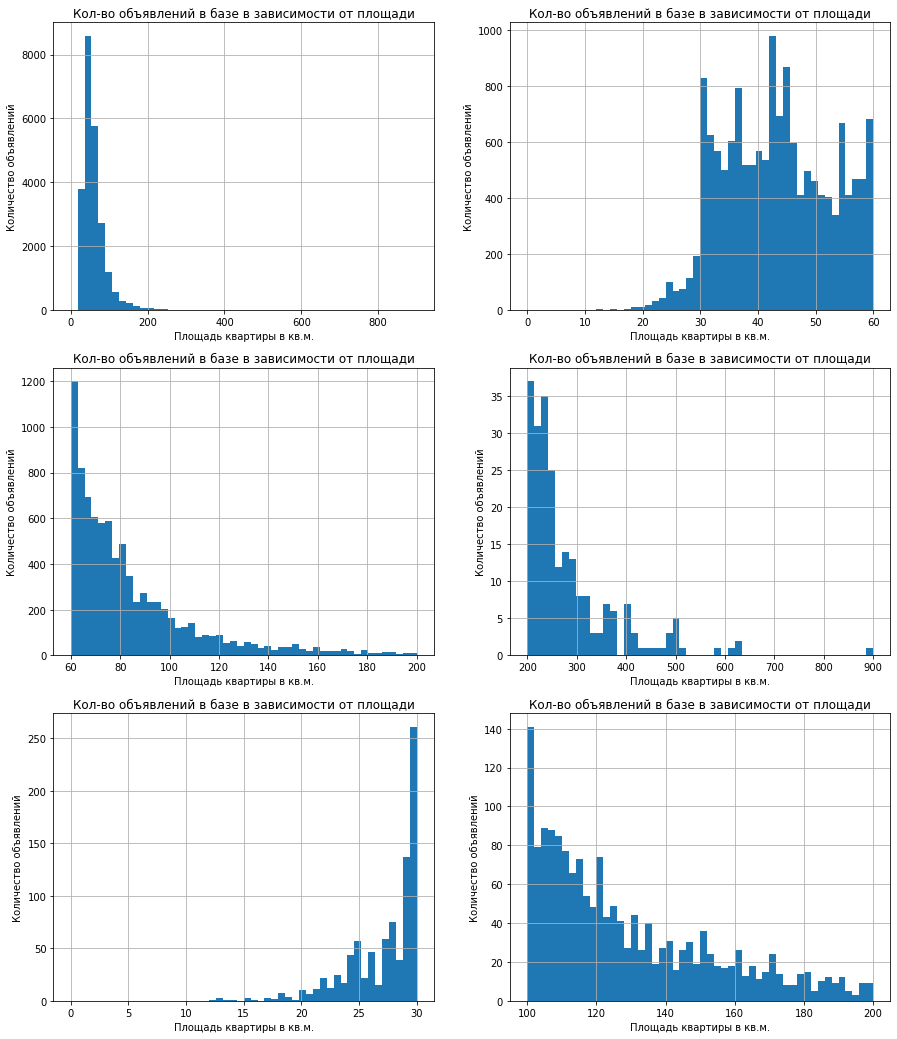

In [42]:
plt.figure(figsize=(15, 18))

plt.subplot(3, 2, 1)
data_estate['total_area'].hist(bins=50, range=(0, 900))
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры в кв.м.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 2)
data_estate['total_area'].hist(bins=50, range=(0, 60))
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры в кв.м.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 3)
data_estate['total_area'].hist(bins=50, range=(60, 200))
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры в кв.м.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 4)
data_estate['total_area'].hist(bins=50, range=(200, 900))
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры в кв.м.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 5)
data_estate['total_area'].hist(bins=50, range=(0, 30))
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры в кв.м.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 6)
data_estate['total_area'].hist(bins=50, range=(100, 200))
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры в кв.м.')
plt.ylabel('Количество объявлений')

Основная масса объявлений с площадью 30-100 кв.м. Значительно меньше объявлений для квартир более 200 кв.м (после 300 кв.м. - единичные случаи. Для обработки задания подойдет область 25 - 140 кв.м. Проверим эту гипотезу через поиск пороговых значений

Text(0, 0.5, 'Количество объявлений')

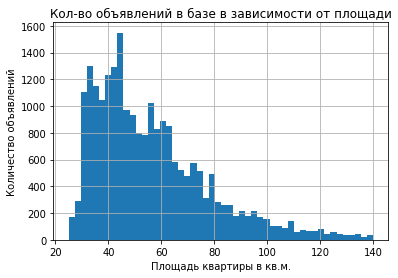

In [43]:
data_estate['total_area'].hist(bins=50, range=(25, 140))
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры в кв.м.')
plt.ylabel('Количество объявлений')

Предположительно такой будет область рассматриваемых значений

#### Найдем пороговые значения по площади квартир с помощью диаграммы размаха

Text(0.5, 0, 'Площадь квартиры 0-40 кв.м.')

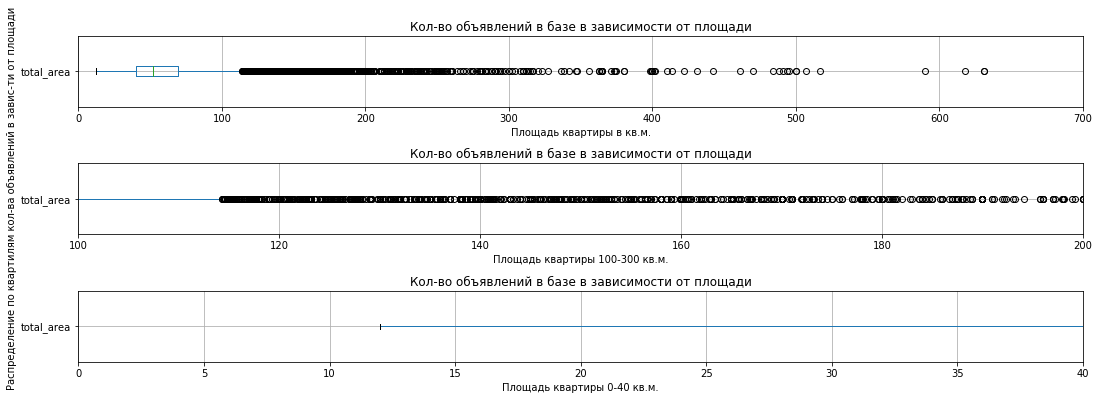

In [44]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace=0, hspace=0.8)

plt.subplot(3, 1, 1)
df_plot = data_estate[['total_area']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(0, 700)  # Проверим весь диапазон от 0 до 700 кв.м.
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры в кв.м.')

plt.subplot(3, 1, 2)
df_plot = data_estate[['total_area']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(100, 200)  # Проверим "хвост" после 100 и до 200 кв.м
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры 100-300 кв.м.')
plt.ylabel('Распределение по квартилям кол-ва объявлений в завис-ти от площади')

plt.subplot(3, 1, 3)
df_plot = data_estate[['total_area']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(0, 40)  # Проверим "маленькие квартиры" до 40 кв.м.
plt.title('Кол-во объявлений в базе в зависимости от площади')
plt.xlabel('Площадь квартиры 0-40 кв.м.')

Диаграмма размаха показывает что самые "маленькие квартиры" - те что в районе 12 кв.м. Получается по нижней границе все объявления входят в задачу. Объявления "выбросы" справа - "большая площадь"  начинаются с диапазона 120-140 кв.м.
Определим границы диапазона через пороговые 2,5% для каждой стороны от общего объема записей. Суммарно можем лишиться около 5% пороговых значений. "Маленькие квартиры" судя по всем графикам можем принять как меньше 20 кв.м. Обозначим "хвост" больших квартир как 130 кв.м. - нам можно потерять не более 5% записей.

In [45]:
too_small_total_area = 20  # "Маленькая квартира" те что меньше 20 кв.м
print('Доля объявлений с "малой" площадью квартиры < {} кв.м.: {:.2%}'
      .format(too_small_total_area, len(data_estate.query('total_area < @too_small_total_area')) / len(data_estate)))

Доля объявлений с "малой" площадью квартиры < 20 кв.м.: 0.11%


In [46]:
too_big_total_area = 130  # "Большая квартира" это более 130 кв.м.
print('Доля объявлений с "большой" площадью квартиры > {} кв.м.: {:.2%}'
      .format(too_big_total_area, len(data_estate.query('total_area > @too_big_total_area')) / len(data_estate)))

Доля объявлений с "большой" площадью квартиры > 130 кв.м.: 3.54%


##### Самыми "маленькими" квартирами будем считать помещения площадью менее 20 кв.м., понятие "большая" квартира рапространяется на метраж более 130 кв.м. Практически те же значения что мы определили по гистаграммам.
####  Ограничения по данным "площадь квартиры" - 20-130 кв.м.

#### Гистограмма по данным "цена квартиры"
проверим данные по столбцу "цена"

In [47]:
# приведем значения в удобочитаемом формате.
data_estate['last_price'].describe().apply('{:,.2f}'.format)

count         23,565.00
mean       6,540,058.26
std       10,910,934.72
min           12,190.00
25%        3,400,000.00
50%        4,646,000.00
75%        6,790,000.00
max      763,000,000.00
Name: last_price, dtype: object

Та же ситуация со стоимостью квартир - очень низкое значение цены в минимальной части. Разница межд средней и медианной ценой есть но в пределах квартиля, средняя цена больше - тоже влияние сверхбольших значений в "хвосте" данных (максимальные значения).

#### Строим гистаграммы по разным диапазонам значений для детального рассмотрения вариантов

Text(0, 0.5, 'Количество объявлений')

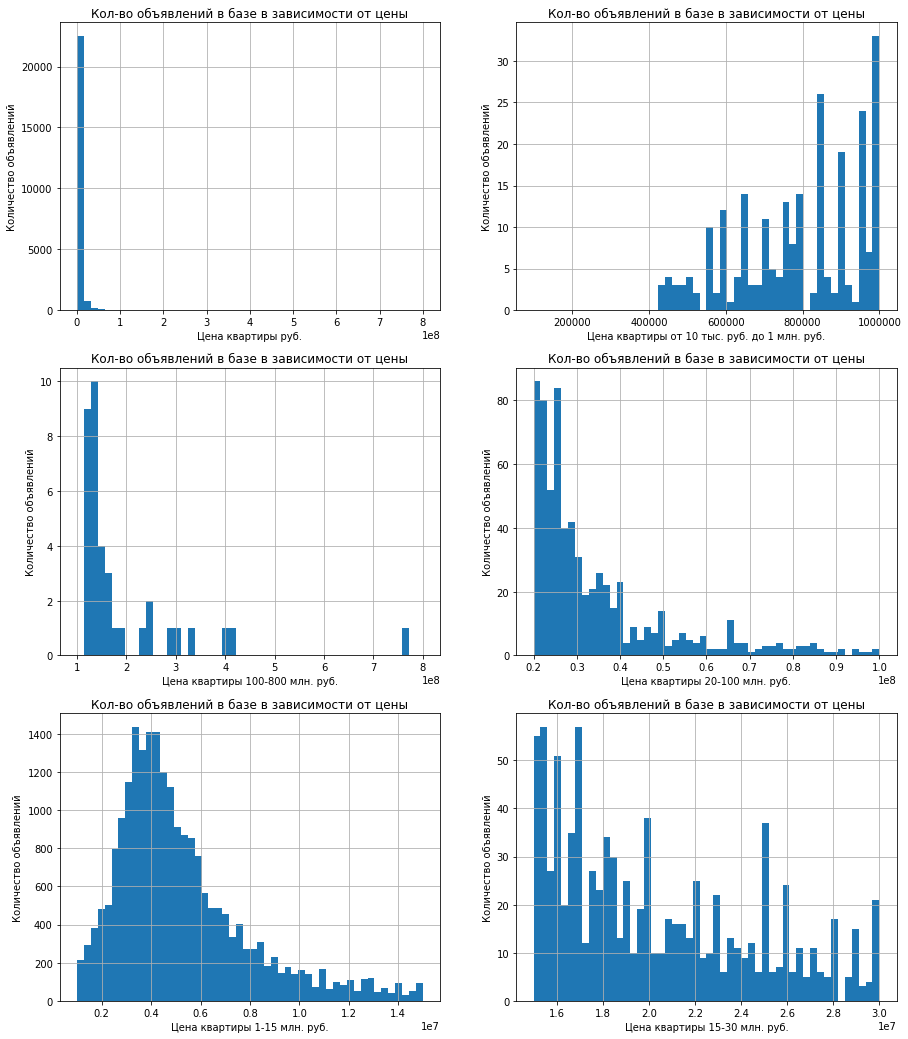

In [48]:
plt.figure(figsize=(15, 18))

plt.subplot(3, 2, 1)
data_estate['last_price'].hist(
    bins=50, range=(10000, 800000000))  # общий график
plt.title('Кол-во объявлений в базе в зависимости от цены')
plt.xlabel('Цена квартиры руб.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 2)
data_estate['last_price'].hist(bins=50, range=(100000, 1000000))
plt.title('Кол-во объявлений в базе в зависимости от цены')
plt.xlabel('Цена квартиры от 10 тыс. руб. до 1 млн. руб.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 3)
data_estate['last_price'].hist(bins=50, range=(100000000, 800000000))
plt.title('Кол-во объявлений в базе в зависимости от цены')
plt.xlabel('Цена квартиры 100-800 млн. руб.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 4)
data_estate['last_price'].hist(bins=50, range=(20000000, 100000000))
plt.title('Кол-во объявлений в базе в зависимости от цены')
plt.xlabel('Цена квартиры 20-100 млн. руб.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 5)
data_estate['last_price'].hist(bins=50, range=(1000000, 15000000))
plt.title('Кол-во объявлений в базе в зависимости от цены')
plt.xlabel('Цена квартиры 1-15 млн. руб.')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 6)
data_estate['last_price'].hist(bins=50, range=(15000000, 30000000))
plt.title('Кол-во объявлений в базе в зависимости от цены')
plt.xlabel('Цена квартиры 15-30 млн. руб.')
plt.ylabel('Количество объявлений')

Разброс цен на квартиры очень большой. Объявления с ценой меньше 400 тыс. руб. явная аномалия, единичные экземпляры. Реальные объявления начинаются с 400 тыс. руб. Единичные случаи продажи квартир в диапазонах 400-600 тыс. руб. и 100-800 млн. руб.  Мало активности также в диапазоне 600 тыс. - 1 млн. руб. и 30-100 млн. руб. Исходя из количества объявлений, возможно есть смысл рассматривать диапазон цен 1-15 млн. руб. и отдельно 15-30 млн. руб. как верхний сегмент.

#### Найдем пороговые значения по стоимости квартир с помощью диаграммы размаха

Text(0.5, 0, 'Цена квартиры до 1 млн. руб.')

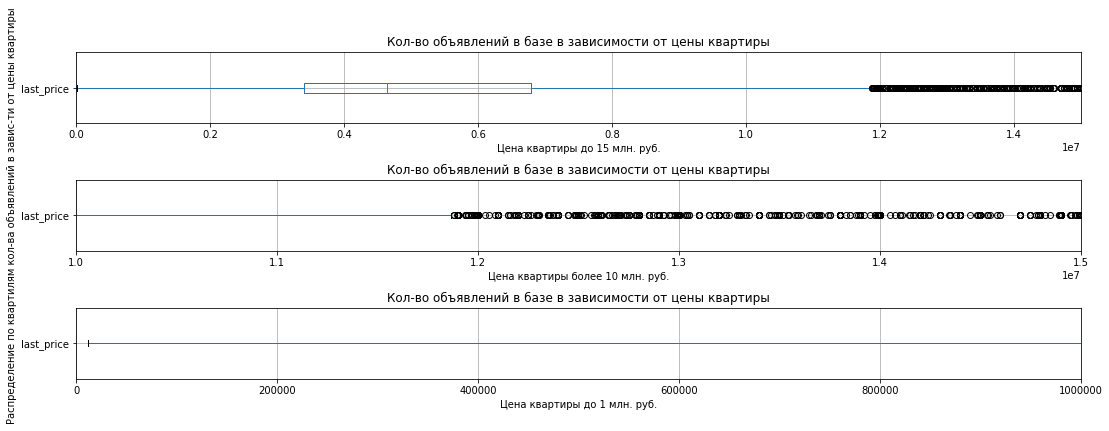

In [49]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace=0, hspace=0.8)

plt.subplot(3, 1, 1)
df_plot = data_estate[['last_price']]
df_plot.boxplot(vert=False, showfliers=True)
plt.title('Кол-во объявлений в базе в зависимости от цены квартиры')
plt.xlim(0, 15000000)  # Проверим весь диапазон от 0 до 15 млн. руб.
plt.xlabel('Цена квартиры до 15 млн. руб.')

plt.subplot(3, 1, 2)
df_plot = data_estate[['last_price']]
df_plot.boxplot(vert=False, showfliers=True)
plt.title('Кол-во объявлений в базе в зависимости от цены квартиры')
plt.xlim(10000000, 15000000)  # Проверим "хвост" после 10 млн. руб.
plt.xlabel('Цена квартиры более 10 млн. руб.')
plt.ylabel('Распределение по квартилям кол-ва объявлений в завис-ти от цены квартиры')

plt.subplot(3, 1, 3)
df_plot = data_estate[['last_price']]
df_plot.boxplot(vert=False, showfliers=True)
plt.title('Кол-во объявлений в базе в зависимости от цены квартиры')
plt.xlim(0, 1000000)  # Проверим "дешевые" квартиры до 1 млн.руб.
plt.xlabel('Цена квартиры до 1 млн. руб.')

Диаграмма размаха показывает что самые "дешевые" квартиры - минимальная стоимость около 12 тыс. руб. Получается по нижней границе все объявления входят в задачу. Объявления "выбросы" справа - "дорогие" квартиры начинаются с 12 млн. руб.
Определим границы диапазона через пороговые 2,5% для каждой стороны от общего объема записей. Суммарно можем лишиться около 5% пороговых значений. "Дешевые" квартиры судя по всем грфикам можем принять как меньше 1 млн. руб. Обозначим "хвост" дорогих как 12 млн. руб. - нам можно потерять не более 5% записей.

- Найдем пороговые значения цен на квартиры

In [50]:
too_small_price = 1000000  # порог в 1 млн. руб.
print('Доля объявлений "дешевых" квартир < {:,} руб.: {:.2%}'
      .format(too_small_price, len(data_estate.query('last_price < @too_small_price')) / len(data_estate)))

Доля объявлений "дешевых" квартир < 1,000,000 руб.: 0.95%


In [51]:
too_big_price = 15000000  # порог в 15 млн. руб.
print('Доля объявлений "дорогих" квартир > {:,} руб.: {:.2%}'
      .format(too_big_price, len(data_estate.query('last_price > @too_big_price')) / len(data_estate)))

Доля объявлений "дорогих" квартир > 15,000,000 руб.: 5.07%


##### Самыми дешевыми считаем квартиры стоимостью менее 1,0 млн. руб., самыми дорогими - стоимостью выше 15 млн.руб. (все-таки их чуть более 5%) 
##### Определили диапазон для анализа - 1-15 млн. руб.

#### Гистограмма по данным "число комнат"
проверим данные по столбцу "число комнат"

In [52]:
data_estate['rooms'].describe()

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Данные распределены нормально, среднее и медиана практически равны. Видно что есть "хвост" из большого количества комнат. Понадобится проверка по нулевым значениям комнат (кол-во и к какой категории относится) и стоит проверить кол-во объявлений где комнат больше общепринятых (нормальных) значений

#### Строим гистаграммы по разным диапазонам значений для детального рассмотрения вариантов

Text(0, 0.5, 'Количество объявлений')

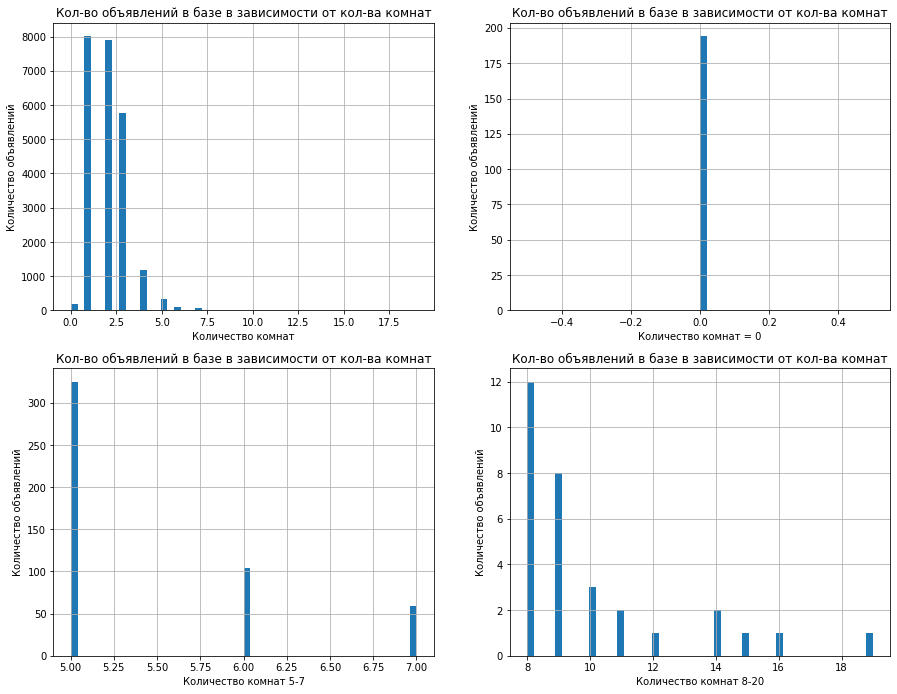

In [53]:
plt.figure(figsize=(15, 18))

plt.subplot(3, 2, 1)
data_estate['rooms'].hist(bins=50, range=(0, 19))  # общий график
plt.title('Кол-во объявлений в базе в зависимости от кол-ва комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 2)
data_estate['rooms'].hist(bins=50, range=(0, 0))
plt.title('Кол-во объявлений в базе в зависимости от кол-ва комнат')
plt.xlabel('Количество комнат = 0')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 3)
data_estate['rooms'].hist(bins=50, range=(5, 7))
plt.title('Кол-во объявлений в базе в зависимости от кол-ва комнат')
plt.xlabel('Количество комнат 5-7')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 4)
data_estate['rooms'].hist(bins=50, range=(8, 19))
plt.title('Кол-во объявлений в базе в зависимости от кол-ва комнат')
plt.xlabel('Количество комнат 8-20')
plt.ylabel('Количество объявлений')

Выясним, что означает "ноль комнат" в контексте объявлений из базы

In [54]:
null_rooms = data_estate['rooms'] == 0
df = data_estate[['rooms', 'studio', 'open_plan', 'is_apartment']]
df.loc[null_rooms]

,rooms,studio,open_plan,is_apartment
144,0,True,False,NaN
347,0,False,True,NaN
438,0,True,False,NaN
505,0,False,True,NaN
605,0,True,False,NaN
...,...,...,...,...
23079,0,True,False,NaN
23310,0,False,True,NaN
23422,0,True,False,NaN
23459,0,False,True,NaN


Пользователи по разному понимали требования указать кол-во комнат - фактически это студии (что логично) либо квартиры со свободной планировкой. Всего таких объявлений 194

Основные продажи сосредоточены в значениях 1-4 комнаты. Картиры студии и со свободной планировкой где пользователь указал "ноль" комнат 194 шт. - менее 1%. Малый сегмент объявлений 5-7 комнат. И единичные объявления где комнат более 8 (до 19  - одна такая). Разумно рассматривать диапазон 1-5 комнат.

#### Найдем пороговые значения по количеству комнат в  квартире с помощью диаграммы размаха

Text(0.5, 0, 'Кол-во комнат в квартире')

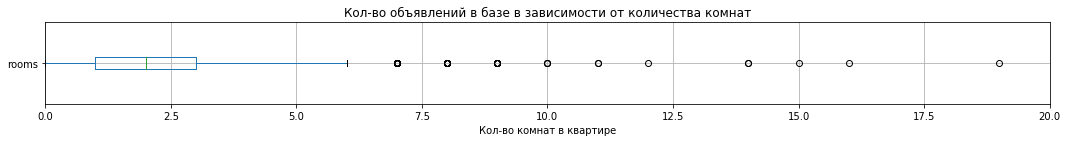

In [55]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace=0, hspace=0.5)

plt.subplot(3, 1, 1)
df_plot = data_estate[['rooms']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(0, 20)  # Проверим весь диапазон.
plt.title('Кол-во объявлений в базе в зависимости от количества комнат')
plt.xlabel('Кол-во комнат в квартире')

Диаграмма размаха показывает что минимальные значения соответствуют студиям и квартирам со свободной планировкой - там где комнат условный "ноль". Объявления "выбросы" справа - квартиры где комнат более 6.
Определим границы диапазона через пороговые 2,5% для каждой стороны от общего объема записей. Суммарно можем лишиться около 5% пороговых значений. Уже решили что 1 комнатные квартиры точно оставляем, справа ограничения до 6 комнат.

In [56]:
too_small_room = 1
print('Доля объявлений с "малым" количеством комнат < {}: {:.2%}'
      .format(too_small_room, len(data_estate.query('rooms < @too_small_room')) / len(data_estate)))

Доля объявлений с "малым" количеством комнат < 1: 0.82%


In [57]:
too_big_room = 6
print('Доля объявлений с "большим" количеством комнат > {}: {:.2%}'
      .format(too_big_room, len(data_estate.query('rooms > @too_big_room')) / len(data_estate)))

Доля объявлений с "большим" количеством комнат > 6: 0.38%


##### Определили диапазон для анализа - от  1 до 6 комнат
Количество объявлений с 1 комнатой менее 1%, но отбрасывать их не имеет смысла из-за узости диапазона - кол-во комнат вообще. Можем отбросить объявления с "0" комнат - их также менее 1% (194 объявления). Верхний диапазон - самые "большие" квартиры - квартиры где более 6 комнат.

#### Гистограмма по данным "высота потолков"
проверим данные по столбцу "высота потолков"

In [58]:
data_estate['ceiling_height'].describe()

count    14481.000000
mean         2.771283
std          1.261983
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Количество данных 2/3 от общего числа записей. Часть пользователей не указывало высоту потолков. Есть явные "выбросы" - 1 метр и 100 метров. В общей массе данные должны быть плотно сгрупированы в районе значений 2,5-3 м., что похоже на правду.

#### Строим гистаграммы по разным диапазонам значений для детального рассмотрения вариантов

Text(0, 0.5, 'Количество объявлений')

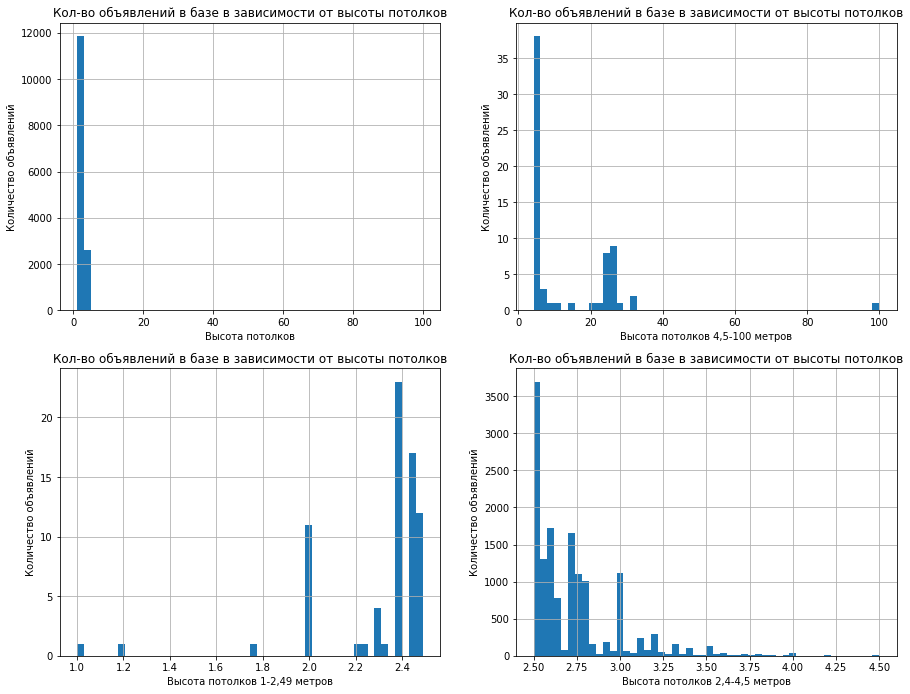

In [59]:
plt.figure(figsize=(15, 18))

plt.subplot(3, 2, 1)
data_estate['ceiling_height'].hist(bins=50, range=(1, 100))  # общий график
plt.title('Кол-во объявлений в базе в зависимости от высоты потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 2)
data_estate['ceiling_height'].hist(bins=50, range=(4.2, 100))
plt.title('Кол-во объявлений в базе в зависимости от высоты потолков')
plt.xlabel('Высота потолков 4,5-100 метров')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 3)
data_estate['ceiling_height'].hist(bins=50, range=(1, 2.49))
plt.title('Кол-во объявлений в базе в зависимости от высоты потолков')
plt.xlabel('Высота потолков 1-2,49 метров')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 4)
data_estate['ceiling_height'].hist(bins=50, range=(2.5, 4.5))
plt.title('Кол-во объявлений в базе в зависимости от высоты потолков')
plt.xlabel('Высота потолков 2,4-4,5 метров')
plt.ylabel('Количество объявлений')

Судя по графикам можно ограничить данные по высоте потолка диапазоном 2,5 до 3,5 метра. Менее 1% квартир с потолками до 2,5 м. (хотя потолки 2,4 - вполне объективная реальность) и с потолками высотой более 4,2 метра. К тому же высота потолков более 10 метров для квартир - явная ошибка.

#### Найдем пороговые значения по категории "высота потолков"

Text(0.5, 0, 'Высота потолков от 2 до 3,5 метров')

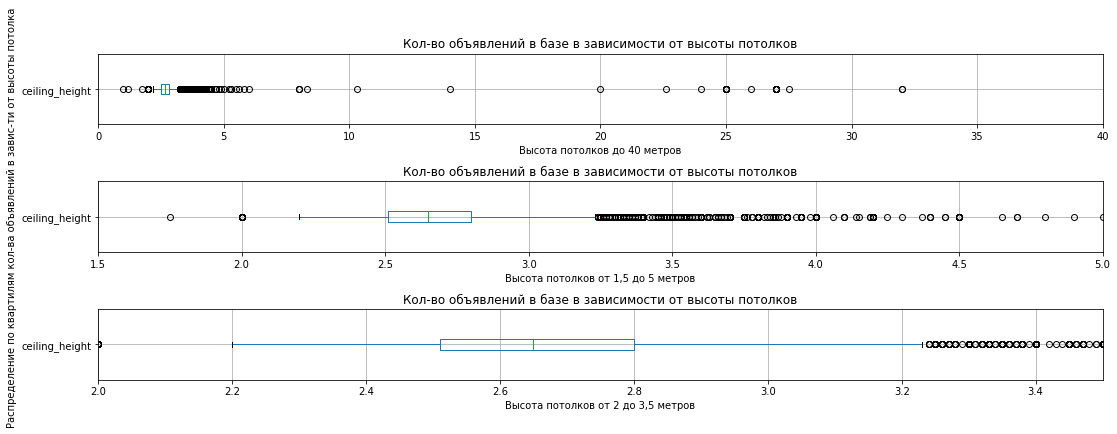

In [60]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace=0, hspace=0.8)

plt.subplot(3, 1, 1)
df_plot = data_estate[['ceiling_height']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(0, 40)  # Проверим весь диапазон до 40 метров высоты.
plt.title('Кол-во объявлений в базе в зависимости от высоты потолков')
plt.xlabel('Высота потолков до 40 метров')

plt.subplot(3, 1, 2)
df_plot = data_estate[['ceiling_height']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(1.5, 5)  # Проверим диапазон до 5 метров высоты.
plt.title('Кол-во объявлений в базе в зависимости от высоты потолков')
plt.xlabel('Высота потолков от 1,5 до 5 метров')
plt.ylabel('Распределение по квартилям кол-ва объявлений в завис-ти от высоты потолка')

plt.subplot(3, 1, 3)
df_plot = data_estate[['ceiling_height']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(2, 3.5)  # Проверим диапазон до 5 метров высоты.
plt.title('Кол-во объявлений в базе в зависимости от высоты потолков')
plt.xlabel('Высота потолков от 2 до 3,5 метров')

Диаграмма размаха показывает что минимальное значение порога - 2,2 м. Объявления "выбросы" справа - квартиры с потолками более 3,3 м. Определим границы диапазона через пороговые 2,5% для каждой стороны от общего объема записей. Суммарно можем лишиться около 5% пороговых значений.

In [61]:
too_small_ceiling = 2.20  # нижний порог потолков 2,2 м
print('Доля объявлений с "низкими" потолками < {} м: {:.2%}'
      .format(too_small_ceiling, len(data_estate.query('ceiling_height < @too_small_ceiling')) / len(data_estate)))

Доля объявлений с "низкими" потолками < 2.2 м: 0.06%


In [62]:
too_big_ceiling = 3.3  # "высокий" порог потолков 3,3 м
print('Доля объявлений с "высокими" потолками > {}: {:.2%}'
      .format(too_big_ceiling, len(data_estate.query('ceiling_height > @too_big_ceiling')) / len(data_estate)))

Доля объявлений с "высокими" потолками > 3.3: 2.57%


##### Квартиры с "низкими" потолками - квартиры где потолки ниже 2,2 м. "Высокие" потолки там где больше 3,3 м. 

#### Изучим время продажи квартиры. 
Построим гистограмму. Посчитаем среднее и медиану. Рассмотрим сколько обычно занимает продажа. Выясним когда можно считать, что продажи прошли очень быстро, а когда слишком долго?

Проверим данные по столбцу кол-ва дней размещения объявления

In [63]:
data_estate['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Минимально объявление продержалось 1 день - выгодное предложение видимо. Максимально более 4 лет. Основной массив объявлений видимо расположен а районе 50-200 дней. срока публикации. Стандартное отклонение немногим больше среднего и сравнимо со значением третьего квартиля. По разнице между максимумом и третьим квартилем видно что есть "длинный хвост" из небольшого количества "длинных объявлений" более года.

#### Строим гистаграммы по разным диапазонам значений для детального рассмотрения вариантов

Text(0, 0.5, 'Количество объявлений')

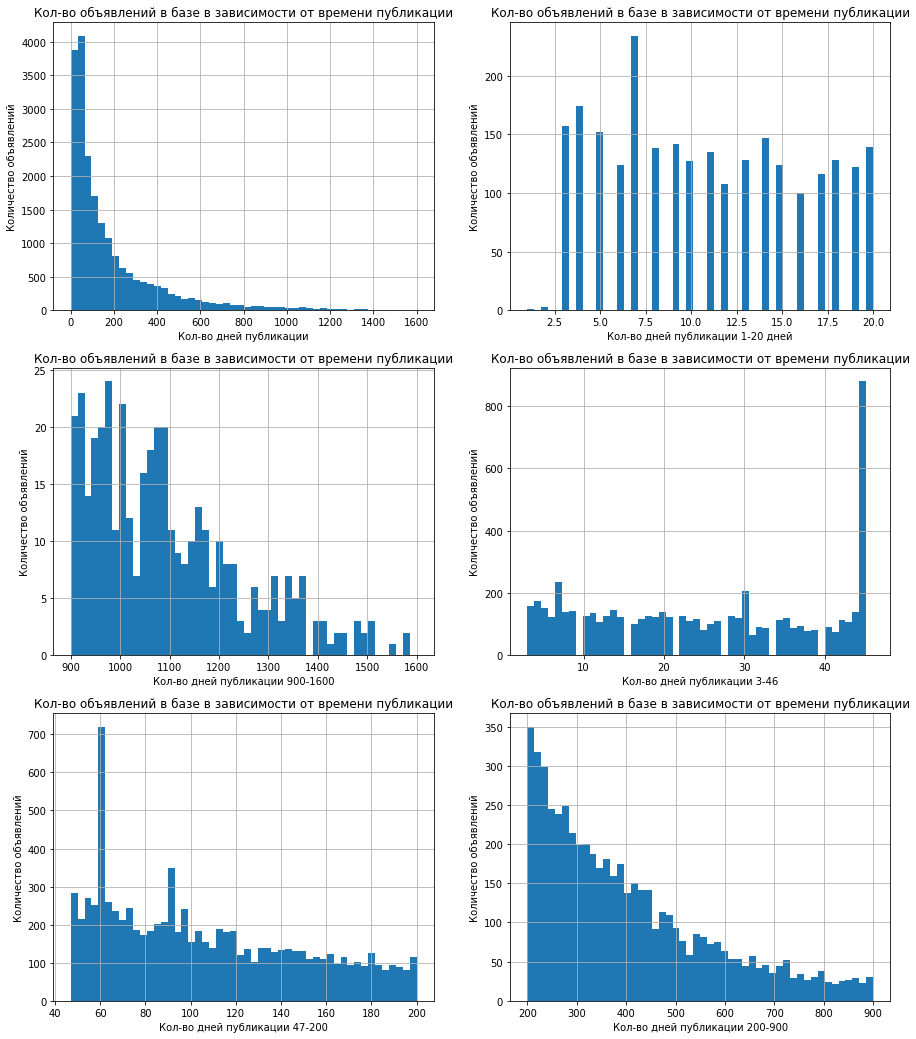

In [64]:
plt.figure(figsize=(15, 18))

plt.subplot(3, 2, 1)
data_estate['days_exposition'].hist(bins=50, range=(1, 1600))  # общий график
plt.title('Кол-во объявлений в базе в зависимости от времени публикации')
plt.xlabel('Кол-во дней публикации')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 2)
data_estate['days_exposition'].hist(bins=50, range=(1, 20))
plt.title('Кол-во объявлений в базе в зависимости от времени публикации')
plt.xlabel('Кол-во дней публикации 1-20 дней')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 3)
data_estate['days_exposition'].hist(bins=50, range=(900, 1600))
plt.title('Кол-во объявлений в базе в зависимости от времени публикации')
plt.xlabel('Кол-во дней публикации 900-1600')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 4)
data_estate['days_exposition'].hist(bins=50, range=(3, 46))
plt.title('Кол-во объявлений в базе в зависимости от времени публикации')
plt.xlabel('Кол-во дней публикации 3-46')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 5)
data_estate['days_exposition'].hist(bins=50, range=(47, 200))
plt.title('Кол-во объявлений в базе в зависимости от времени публикации')
plt.xlabel('Кол-во дней публикации 47-200')
plt.ylabel('Количество объявлений')

plt.subplot(3, 2, 6)
data_estate['days_exposition'].hist(bins=50, range=(200, 900))
plt.title('Кол-во объявлений в базе в зависимости от времени публикации')
plt.xlabel('Кол-во дней публикации 200-900')
plt.ylabel('Количество объявлений')

Количество объявлений более 100 начинаются примерно с 3 дней с момента публикации и после 600-700 дней количество объявлений заметно падает.

#### Найдем пороговые значения по категории "кол-во дней публикации"

Text(0.5, 0, 'Кол-во дней публикации 0-10 дней')

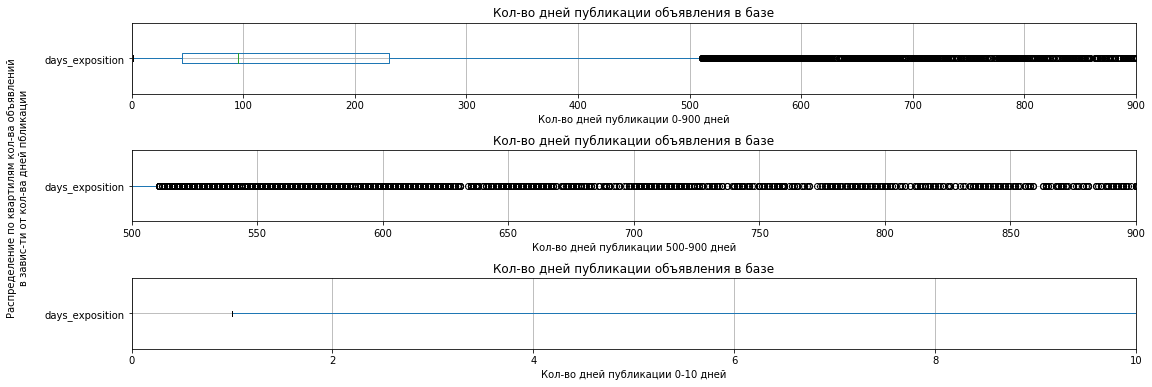

In [65]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace=0, hspace=0.8)

plt.subplot(3, 1, 1)
df_plot = data_estate[['days_exposition']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(0, 900)  # Проверим весь диапазон сроков публикаций от 0 до 900
plt.title('Кол-во дней публикации объявления в базе')
plt.xlabel('Кол-во дней публикации 0-900 дней')

plt.subplot(3, 1, 2)
df_plot = data_estate[['days_exposition']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(500, 900)  # Проверим "хвост" после 500 дней
plt.title('Кол-во дней публикации объявления в базе')
plt.xlabel('Кол-во дней публикации 500-900 дней')
plt.ylabel('Распределение по квартилям кол-ва объявлений \nв завис-ти от кол-ва дней пбликации \n ')

plt.subplot(3, 1, 3)
df_plot = data_estate[['days_exposition']]
df_plot.boxplot(vert=False, showfliers=True)
plt.xlim(0, 10)  # Проверим "короткие" обявления до 10 дней
plt.title('Кол-во дней публикации объявления в базе')
plt.xlabel('Кол-во дней публикации 0-10 дней')

Диаграмма размаха показывает что самые короткие объявления - те что продержались меньше одного дня. Объявления - "выбросы" с большим сроком публикации начинаются примерно с 520 дней.   
Определим самые короткие и самые длинные продажи в базе, через пороговые значения  - обозначим как 2,5% для каждого типа от общего объема записей. Суммарно можем лишиться около 5% пороговых значений. "Короткие" объявления судя по всем грфикам можем принять как меньше 3 дней. Обозначим "хвост" длинных как 600 дней - нам можно потерять не более 5% записей.

In [66]:
too_small_days_exp = 3  # самые "короткие" объявления до 3 дней
print('Доля объявлений с "коротким" сроком жизни < {} дней: {:.2%}'
      .format(too_small_days_exp, len(data_estate.query('days_exposition < @too_small_days_exp')) / len(data_estate)))

Доля объявлений с "коротким" сроком жизни < 3 дней: 0.02%


In [67]:
too_long_days_exp = 600  # самые "длинные" объявления более 600 дней
print('Доля объявлений со слишком "большим" сроком жизни > {} дней: {:.2%}'
      .format(too_long_days_exp, len(data_estate.query('days_exposition > @too_long_days_exp')) / len(data_estate)))

Доля объявлений со слишком "большим" сроком жизни > 600 дней: 5.06%


##### Можно считать что слишком быстрая продажа это меньше 3 дней, а самые длинные это срок более 600 дней с момента старта продаж. 

#### Какие факторы больше всего влияют на стоимость квартиры?   
Изучим, зависит ли цена от квадратного метра, числа комнат, удалённости от центра. Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом, а также зависимость от даты размещения: дня недели, месяца и года.  
   
        - Создадим массив данных под задачу.

In [68]:
data_estate.columns  # отметим нужные нам колонки

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'cost_per_sq_m',
       'share_living_total', 'share_kitchen_total', 'day_week', 'month',
       'year', 'floor_group'],
      dtype='object')

In [69]:
data_estate_price = data_estate[['last_price', 'total_area', 'rooms', 'cityCenters_nearest', 'day_week', 'month',
                                 'year', 'floor_group']]
data_estate_price.head()  # создали массив данных под задачу

,last_price,total_area,rooms,cityCenters_nearest,day_week,month,year,floor_group
0,13000000.0,108.0,3,16028.0,3,3,2019,другое
1,3350000.0,40.4,1,18603.0,1,12,2018,первый этаж
2,5196000.0,56.0,2,13933.0,3,8,2015,другое
3,64900000.0,159.0,3,6800.0,4,7,2015,другое
4,10000000.0,100.0,2,8098.0,1,6,2018,другое


Введем ограничения сверху и снизу выявленные ранее

In [70]:
data_estate_price_ok = data_estate_price \
    .query('last_price >= @too_small_price & last_price <= @too_big_price & \
    total_area >= @too_small_total_area & total_area <= @too_big_total_area & \
     rooms >= @too_small_room & rooms <= @too_big_room')
data_estate_price_ok.head() # проверка

,last_price,total_area,rooms,cityCenters_nearest,day_week,month,year,floor_group
0,13000000.0,108.0,3,16028.0,3,3,2019,другое
1,3350000.0,40.4,1,18603.0,1,12,2018,первый этаж
2,5196000.0,56.0,2,13933.0,3,8,2015,другое
4,10000000.0,100.0,2,8098.0,1,6,2018,другое
5,2890000.0,30.4,1,NaN,0,9,2018,другое


In [71]:
data_estate_price_ok.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21746 entries, 0 to 23564
Data columns (total 8 columns):
last_price             21746 non-null float64
total_area             21746 non-null float64
rooms                  21746 non-null int64
cityCenters_nearest    16581 non-null float64
day_week               21746 non-null int64
month                  21746 non-null int64
year                   21746 non-null int64
floor_group            21746 non-null object
dtypes: float64(3), int64(4), object(1)
memory usage: 1.5+ MB


In [72]:
print('В результате наложенных ограничений потеряли {:.2%} данных'.format(
    1-(data_estate_price_ok.shape[0] / data_estate.shape[0])))

В результате наложенных ограничений потеряли 7.72% данных


На первый взгляд потери большие(?), но они явно из-за обрезаных "хвостов" по максимальным значениям данных. 

Изучим зависимости цены квартиры от других факторов. Проверим зависимость цены на квартиру от следущих параметров: квадратного метра, числа комнат, удалённости от центра, На каком этаже расположена квартира: первом, последнем или другом, а также от даты размещения: дня недели, месяца и года. 

Функция корреляции не работает с нечисловыми данными поэтому заменим категории первый, последний и другой этаж на числа.

In [73]:
df_floor_group = data_estate_price_ok['floor_group']

# проведем замену категоральных данных на числовые.
df_floor_group = df_floor_group.replace('другое', 2)
df_floor_group = df_floor_group.replace('первый этаж', 1)
df_floor_group = df_floor_group.replace('последний этаж', 3)

data_estate_price_ok = pd.merge(
    data_estate_price_ok, df_floor_group, right_index=True, left_index=True)
data_estate_price_ok.head()  # проверка

,last_price,total_area,rooms,cityCenters_nearest,day_week,month,year,floor_group_x,floor_group_y
0,13000000.0,108.0,3,16028.0,3,3,2019,другое,2
1,3350000.0,40.4,1,18603.0,1,12,2018,первый этаж,1
2,5196000.0,56.0,2,13933.0,3,8,2015,другое,2
4,10000000.0,100.0,2,8098.0,1,6,2018,другое,2
5,2890000.0,30.4,1,NaN,0,9,2018,другое,2


Построим таблицу взаимных корреляций

In [74]:
data_estate_price_ok.corr()

,last_price,total_area,rooms,cityCenters_nearest,day_week,month,year,floor_group_y
last_price,1.000000,0.736786,0.459266,-0.356703,-0.013275,0.008948,-0.004606,0.044416
total_area,0.736786,1.000000,0.798220,-0.165982,-0.010574,0.015165,-0.063188,0.018060
rooms,0.459266,0.798220,1.000000,-0.105439,-0.001272,0.003088,-0.035207,-0.009441
cityCenters_nearest,-0.356703,-0.165982,-0.105439,1.000000,0.006878,-0.015540,0.018515,-0.016197
day_week,-0.013275,-0.010574,-0.001272,0.006878,1.000000,0.012436,-0.000351,0.006113
month,0.008948,0.015165,0.003088,-0.015540,0.012436,1.000000,-0.269830,0.008887
year,-0.004606,-0.063188,-0.035207,0.018515,-0.000351,-0.269830,1.000000,0.012918
floor_group_y,0.044416,0.018060,-0.009441,-0.016197,0.006113,0.008887,0.012918,1.000000


Построим график взаимных корреляций с помощью "тепловой карты"

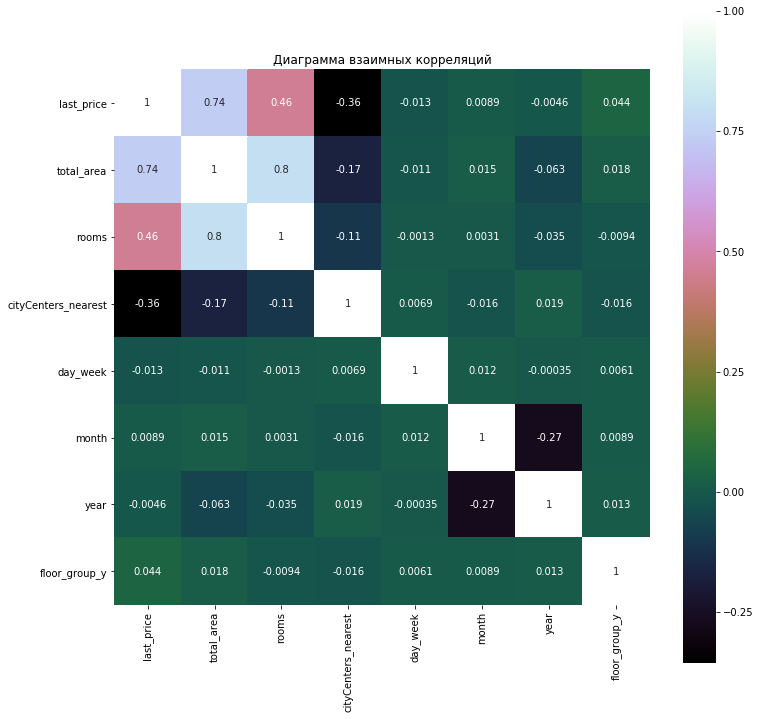

In [75]:
correlation = data_estate_price_ok.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

plt.title('Диаграмма взаимных корреляций')
plt.show()  # просто захотелось попробывать потому что синтаксис простой.

- Цена квартиры НЕ ЗАВИСИТ от даты размещения объявления - коэф. корреляции равен практически 0   
- СИЛЬНАЯ зависимость, но не линейная, от площади квартиры - коэф корреляции более 0,7 - чем больше квартира, тем больше цена.   
- Слабая зависимость от количества комнат (0,46) и удаленности от центра (-0,36), причем чем ближе к центру, тем стоимость квартир больше.
- Зависимость цены квартиры от этажа (в категориях "первый, последний, другой") фактически отсутствует - как бы странно.

Проверим зависимость цен квартир от этажности через медиану и среднее значения 

In [76]:
# приведем цены в более читабельный вид
pd.options.display.float_format = '{:,.2f}'.format

data_estate_price_ok.groupby('floor_group_x').agg(
    {'last_price': ['median', 'mean', 'count']}).sort_values(by=[('last_price', 'median')])

last_price                    
                     median         mean  count
floor_group_x                                  
первый этаж    3,900,000.00 4,350,616.84   2729
последний этаж 4,200,000.00 4,853,162.61   2983
другое         4,700,000.00 5,359,896.95  16034

Получается, что судя по базе, категория этажности не влияет на цену квартир и средние и медианные значения слабо менются в зависимости от этажности.

#### Выберем 10 населённых пунктов с наибольшим числом объявлений.    
Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

Подготовим данные

In [77]:
data_estate.columns  # отметим нужные нам колонки

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'cost_per_sq_m',
       'share_living_total', 'share_kitchen_total', 'day_week', 'month',
       'year', 'floor_group'],
      dtype='object')

Введем ограничения сверху и снизу выявленные ранее

In [78]:
data_estate_locate = data_estate.query('@too_small_price <= last_price <= @too_big_price') \
    .pivot_table(index='locality_name', values=['cost_per_sq_m', 'last_price'],
                 aggfunc={'cost_per_sq_m': 'mean', 'last_price': ['count', 'max', 'min']})

# заменим название колонок
data_estate_locate.columns = ['cost_per_sq_m_mean',
                              'ad_count', 'last_price_max', 'last_price_min']

print('TOП 10 населенных пунктов где больше всего объявлений')
print('с данными по среднему значению стоимости за кв.м. и макс. и мин. ценой квартиры')
data_estate_locate.sort_values(by='ad_count', ascending=False).head(10)

TOП 10 населенных пунктов где больше всего объявлений
с данными по среднему значению стоимости за кв.м. и макс. и мин. ценой квартиры


,cost_per_sq_m_mean,ad_count,last_price_max,last_price_min
locality_name,,,,
Санкт-Петербург,"107,264.85",14492,"15,000,000.00","1,190,000.00"
п. Мурино,"85,629.57",552,"8,500,000.00","1,730,000.00"
п. Шушары,"78,551.34",439,"10,990,000.00","1,500,000.00"
Всеволожск,"67,275.59",396,"11,000,000.00","1,150,000.00"
Пушкин,"101,197.27",351,"15,000,000.00","1,990,000.00"
Колпино,"75,333.30",337,"12,750,000.00","2,100,000.00"
п. Парголово,"90,175.91",327,"9,140,000.00","1,400,000.00"
Гатчина,"68,935.19",306,"13,900,000.00","1,050,000.00"
д. Кудрово,"92,473.55",299,"13,000,000.00","1,800,000.00"


Больше всего объявлений, ожидаемо, в Санкт-Петербурге. Тут же самая высокая цена за кв. метр и самая высокая максимальная цена. Максимальные цены почти везеде больше 10 млн.руб. Минимальные цены в диапазоне 1-2 млн.руб.

#### Изучим предложения квартир в Санкт-Петербурге:
- Выясним, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах (округлим до целых значений). 
- Посчитаем среднюю цену для каждого километра. 
- Построим график: зависимость цены от удалённости от центра. 
- Определим границу, где график сильно меняется — это и будет центральная зона.

Соберем базу объявлений по Санкт-Петербургу. Введем ограничения по столбцу 'locality_name'

In [79]:
# переменная для всех объявлений по Санкт-Петербургу
locality_piter = data_estate['locality_name'] == 'Санкт-Петербург'
data_estate.columns # отметим нужные нам колонки

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'cost_per_sq_m',
       'share_living_total', 'share_kitchen_total', 'day_week', 'month',
       'year', 'floor_group'],
      dtype='object')

In [80]:
# подготовим данные для задачи 
data_locality_piter = data_estate[['locality_name', 'last_price', 'cityCenters_nearest']].query(
    '@locality_piter & @too_small_price <= last_price <= @too_big_price')
data_locality_piter.head()

,locality_name,last_price,cityCenters_nearest
0,Санкт-Петербург,"13,000,000.00","16,028.00"
2,Санкт-Петербург,"5,196,000.00","13,933.00"
4,Санкт-Петербург,"10,000,000.00","8,098.00"
7,Санкт-Петербург,"7,915,000.00","11,634.00"
9,Санкт-Петербург,"5,400,000.00","15,008.00"


Создадим столбец с расстоянием до центра в км.  
Проверим кол-во нулевых значений по параметру "расстояние до центра" 

In [81]:
data_locality_piter.info() # проверим состав отфильтрованных данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14492 entries, 0 to 23563
Data columns (total 3 columns):
locality_name          14492 non-null object
last_price             14492 non-null float64
cityCenters_nearest    14447 non-null float64
dtypes: float64(2), object(1)
memory usage: 452.9+ KB


Есть 45 нулевых значений по расстоянию от центра, удалим их. Расстояние от центра "трудно" будет восстановить по другим параметрам, будь это не Санк-Петербург можно было бы проанализировать расстояние до воды и сверится с картой, но в этом случае это не реально.

In [82]:
# удаляем нулевые данные
data_locality_piter = data_locality_piter.dropna(subset=['cityCenters_nearest']).reset_index(drop=True)
data_locality_piter.info()  # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Data columns (total 3 columns):
locality_name          14447 non-null object
last_price             14447 non-null float64
cityCenters_nearest    14447 non-null float64
dtypes: float64(2), object(1)
memory usage: 338.7+ KB


In [83]:
# создаем столбец с расстоянием до центра в км.
data_locality_piter['cityCenters_nearest_km'] = (
    (data_locality_piter['cityCenters_nearest'] / 1000).astype('int'))
# удалим ненужный столбец.
data_locality_piter = data_locality_piter.drop(
    data_locality_piter.columns[2], axis='columns')
data_locality_piter.head()

,locality_name,last_price,cityCenters_nearest_km
0,Санкт-Петербург,"13,000,000.00",16
1,Санкт-Петербург,"5,196,000.00",13
2,Санкт-Петербург,"10,000,000.00",8
3,Санкт-Петербург,"7,915,000.00",11
4,Санкт-Петербург,"5,400,000.00",15


Посмотрим в какой зоне стоимости и расстояния до центра больше всего объявлений по г. Санкт-Петербургу

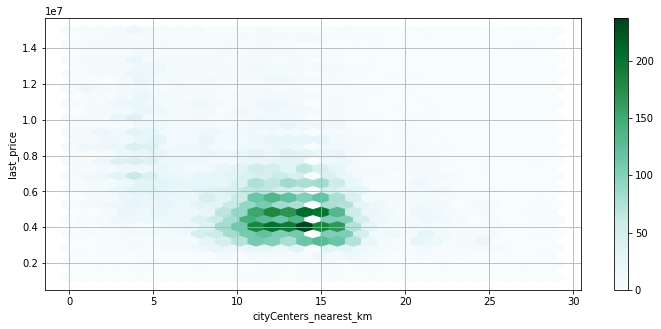

In [84]:
data_locality_piter.plot(x='cityCenters_nearest_km', y='last_price',
                         kind='hexbin', sharex=False, gridsize=30, grid=True, figsize=(12, 5))

Больше всего объявлений по Санкт-Петербургу в ценовом диапазоне 3,5-6 млн. руб. от 12 до 15 км от центра (новостройки?)

Посчитаем среднюю цену для каждого километра по удаленности от центра.

In [85]:
df_mean_price = data_locality_piter.groupby('cityCenters_nearest_km').mean()
df_mean_price.columns = ['last_price_mean']
df_mean_price

,last_price_mean
cityCenters_nearest_km,
0,"9,366,537.04"
1,"9,280,034.28"
2,"8,691,204.72"
3,"8,369,018.42"
4,"8,743,684.02"
5,"8,097,521.34"
6,"7,587,976.31"
7,"7,299,897.10"
8,"6,819,164.06"


Построим график зависимости средней цены от расстояния до центра

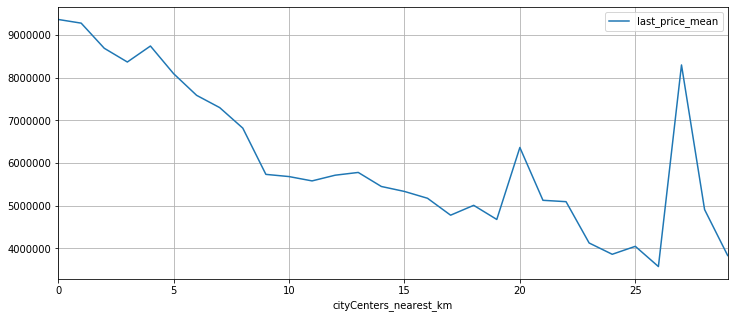

In [86]:
df_mean_price.plot(grid=True, figsize=(12, 5))

В отличии от первого графика более информативно. Заметное падение цены после радиуса 5 км. от центра. Два пика в районе 20 км. и в районе 27 км. Не знаю так хорошо город, но возможно это радиус пригорода с элитными районами.    
##### Считаем что радиус объявлений из центра - 5 км

#### Изучим сегмент квартир в центре. 
- Проанализируем в этих пределах следующие параметры: 
    - площадь, цена, число комнат, высота потолков. 
- Выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). 
- Проверим отличаются ли они от общих выводов по всему городу?

Подготовим данные

In [87]:
data_estate.columns # отметим нужные нам колонки

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'cost_per_sq_m',
       'share_living_total', 'share_kitchen_total', 'day_week', 'month',
       'year', 'floor_group'],
      dtype='object')

In [88]:
# ограничение зоны - только центр - до 5 км радиус расположения квартир
local_piter_centr = data_estate['cityCenters_nearest'] <= 5000

In [89]:
# создаем таблицу из нужных наборов данных
data_piter_centr = data_estate[['locality_name', 'last_price', 'cityCenters_nearest', 'total_area', 'rooms',
                                'ceiling_height', 'floor_group', 'first_day_exposition', 'day_week', 'month', 'year']]

# применяем ограничения по данным - только Санкт-Петербург, и другие выделенные ранее по цене, высоте потолков и т.д.
data_piter_centr = data_piter_centr.query('@locality_piter & @local_piter_centr & \
                                            @too_small_price <= last_price <= @too_big_price & \
                                            @too_small_total_area <= total_area <= @too_big_total_area & \
                                            @too_small_ceiling <= ceiling_height <= @too_big_ceiling & \
                                            rooms <= @too_big_room')  # комнат меньше одной нет в Санкт-Петербурге

data_piter_centr.head()  # проверка

,locality_name,last_price,cityCenters_nearest,total_area,rooms,ceiling_height,floor_group,first_day_exposition,day_week,month,year
137,Санкт-Петербург,"13,310,800.00","4,263.00",85.10,2,2.70,другое,2018-01-01,0,1,2018
159,Санкт-Петербург,"7,050,000.00","4,937.00",66.00,3,3.00,последний этаж,2017-09-04,0,9,2017
181,Санкт-Петербург,"7,900,000.00","3,301.00",71.80,3,3.00,первый этаж,2017-08-23,2,8,2017
200,Санкт-Петербург,"10,880,000.00","3,369.00",123.10,6,3.20,другое,2015-11-12,3,11,2015
206,Санкт-Петербург,"9,000,000.00","1,645.00",72.60,2,2.90,другое,2018-09-08,5,9,2018


In [90]:
data_piter_centr.info() # проверка

<class 'pandas.core.frame.DataFrame'>
Int64Index: 764 entries, 137 to 23557
Data columns (total 11 columns):
locality_name           764 non-null object
last_price              764 non-null float64
cityCenters_nearest     764 non-null float64
total_area              764 non-null float64
rooms                   764 non-null int64
ceiling_height          764 non-null float64
floor_group             764 non-null object
first_day_exposition    764 non-null datetime64[ns]
day_week                764 non-null int64
month                   764 non-null int64
year                    764 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 71.6+ KB


Нужно создать столбец про этажность в числовом варианте для применения функции корреляции

In [91]:
# проведем замену категоральных данных на числовые.
df_floor_group = data_piter_centr['floor_group']

df_floor_group = df_floor_group.replace('другое', 2)
df_floor_group = df_floor_group.replace('первый этаж', 1)
df_floor_group = df_floor_group.replace('последний этаж', 3)

data_piter_centr = pd.merge(
    data_piter_centr, df_floor_group, right_index=True, left_index=True)
data_piter_centr.head()  # проверка

,locality_name,last_price,cityCenters_nearest,total_area,rooms,ceiling_height,floor_group_x,first_day_exposition,day_week,month,year,floor_group_y
137,Санкт-Петербург,"13,310,800.00","4,263.00",85.10,2,2.70,другое,2018-01-01,0,1,2018,2
159,Санкт-Петербург,"7,050,000.00","4,937.00",66.00,3,3.00,последний этаж,2017-09-04,0,9,2017,3
181,Санкт-Петербург,"7,900,000.00","3,301.00",71.80,3,3.00,первый этаж,2017-08-23,2,8,2017,1
200,Санкт-Петербург,"10,880,000.00","3,369.00",123.10,6,3.20,другое,2015-11-12,3,11,2015,2
206,Санкт-Петербург,"9,000,000.00","1,645.00",72.60,2,2.90,другое,2018-09-08,5,9,2018,2


Построим таблицу взаимных корреляций

In [92]:
data_piter_centr.corr()

,last_price,cityCenters_nearest,total_area,rooms,ceiling_height,day_week,month,year,floor_group_y
last_price,1.00,-0.02,0.65,0.38,0.14,-0.04,-0.03,0.01,0.18
cityCenters_nearest,-0.02,1.00,-0.09,-0.11,-0.03,-0.07,-0.01,0.03,-0.08
total_area,0.65,-0.09,1.00,0.76,0.21,-0.06,-0.02,-0.07,0.15
rooms,0.38,-0.11,0.76,1.00,0.17,-0.05,-0.01,-0.04,0.09
ceiling_height,0.14,-0.03,0.21,0.17,1.00,0.00,0.01,0.03,-0.02
day_week,-0.04,-0.07,-0.06,-0.05,0.00,1.00,0.05,0.02,0.08
month,-0.03,-0.01,-0.02,-0.01,0.01,0.05,1.00,-0.22,-0.05
year,0.01,0.03,-0.07,-0.04,0.03,0.02,-0.22,1.00,0.02
floor_group_y,0.18,-0.08,0.15,0.09,-0.02,0.08,-0.05,0.02,1.00


Построим график взаимных корреляций с помощью "тепловой карты"

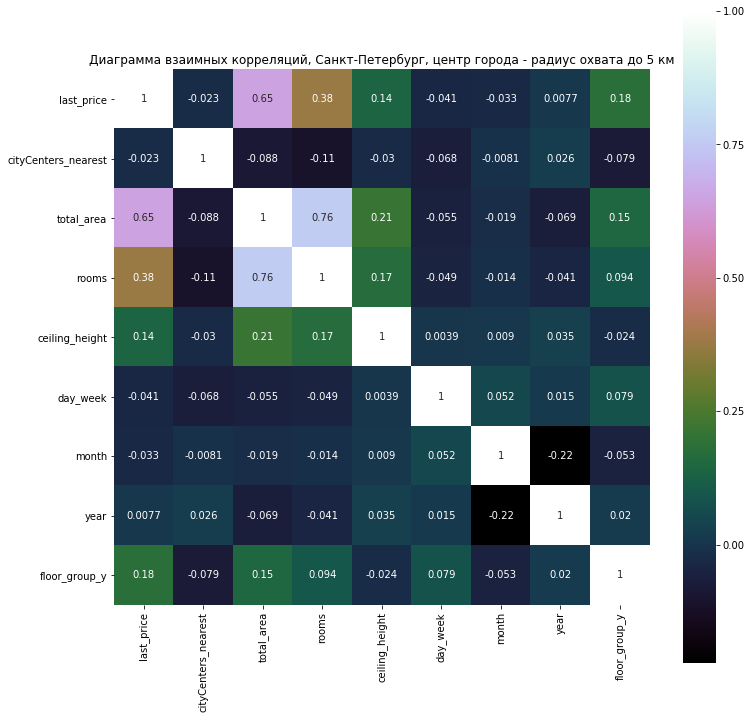

In [93]:
correlation_piter_centre = data_piter_centr.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_piter_centre, vmax=1,
            square=True, annot=True, cmap='cubehelix')

plt.title('Диаграмма взаимных корреляций, Санкт-Петербург, центр города - радиус охвата до 5 км')
plt.show()  # просто захотелось попробывать потому что синтаксис простой.

- Цена квартиры НЕ ЗАВИСИТ (коэф. корреляции равен практически равен 0) от:
    - высоты потолков
    - даты размещения объявления
    - этажности
    - удаленности от центра (она и так в центре)
- Цена квартиры зависит, от площади квартиры - коэф корреляции 0,65 - чем больше квартира, тем больше цена.   
- Слабая зависимость от количества комнат в квартире (0,38).

По сравнению с ситуацией когда мы расссматривали всю базу - Санкт-Петербург и пригороды есть различия
- Зависимость цены квартиры от площади была выше - 0,74
- Зависимость от количества комнат была больше 0,46 (несущественно)
- Зависимость от удаленности от центра была ощутимо выше -0,36, по сравнению с показателями по центру Санкт-Петербурга, что естественно, ведь данные ограничили радиусом "центра "Санкт-Петербурга" т.е фактически исключили этот параметр из анализа.

Снимем одно ограничение "центр города" и проверим весь Санкт-Петербург

In [94]:
# создаем таблицу из нужных наборов данных
data_piter_all = data_estate[['locality_name', 'last_price', 'cityCenters_nearest', 'total_area', 'rooms',
                              'ceiling_height', 'floor_group', 'first_day_exposition', 'day_week', 'month', 'year']]

# применяем ограничения по данным - только Санкт-Петербург, и другие выделенные ранее по цене, высоте потолков и т.д.
data_piter_all = data_piter_all.query('@locality_piter & \
                                            @too_small_price <= last_price <= @too_big_price & \
                                            @too_small_total_area <= total_area <= @too_big_total_area & \
                                            @too_small_ceiling <= ceiling_height <= @too_big_ceiling & \
                                            rooms <= @too_big_room')  # комнат меньше одной нет в Санкт-Петербурге

data_piter_all.head()  # проверка

,locality_name,last_price,cityCenters_nearest,total_area,rooms,ceiling_height,floor_group,first_day_exposition,day_week,month,year
0,Санкт-Петербург,"13,000,000.00","16,028.00",108.00,3,2.70,другое,2019-03-07,3,3,2019
4,Санкт-Петербург,"10,000,000.00","8,098.00",100.00,2,3.03,другое,2018-06-19,1,6,2018
9,Санкт-Петербург,"5,400,000.00","15,008.00",61.00,3,2.50,другое,2017-02-26,6,2,2017
10,Санкт-Петербург,"5,050,000.00","13,878.00",39.60,1,2.67,другое,2017-11-16,3,11,2017
16,Санкт-Петербург,"6,700,000.00","10,698.00",82.00,3,3.05,первый этаж,2017-11-23,3,11,2017


In [95]:
data_piter_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8860 entries, 0 to 23563
Data columns (total 11 columns):
locality_name           8860 non-null object
last_price              8860 non-null float64
cityCenters_nearest     8839 non-null float64
total_area              8860 non-null float64
rooms                   8860 non-null int64
ceiling_height          8860 non-null float64
floor_group             8860 non-null object
first_day_exposition    8860 non-null datetime64[ns]
day_week                8860 non-null int64
month                   8860 non-null int64
year                    8860 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 830.6+ KB


Нулевые значения "расстояние до центра" нужно убрать

In [96]:
data_piter_all = data_piter_all.dropna(axis='index', how='any',
                                       subset=['cityCenters_nearest']).reset_index(drop=True)
data_piter_all.info()  # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 11 columns):
locality_name           8839 non-null object
last_price              8839 non-null float64
cityCenters_nearest     8839 non-null float64
total_area              8839 non-null float64
rooms                   8839 non-null int64
ceiling_height          8839 non-null float64
floor_group             8839 non-null object
first_day_exposition    8839 non-null datetime64[ns]
day_week                8839 non-null int64
month                   8839 non-null int64
year                    8839 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 759.7+ KB


Нужно создать столбец про этажность в числовом варианте для применения функции корреляции

In [97]:
# проведем замену категоральных данных на числовые.
df_floor_group = data_piter_all['floor_group']

df_floor_group = df_floor_group.replace('другое', 2)
df_floor_group = df_floor_group.replace('первый этаж', 1)
df_floor_group = df_floor_group.replace('последний этаж', 3)

data_piter_all = pd.merge(
    data_piter_all, df_floor_group, right_index=True, left_index=True)
data_piter_all.head()  # проверка

,locality_name,last_price,cityCenters_nearest,total_area,rooms,ceiling_height,floor_group_x,first_day_exposition,day_week,month,year,floor_group_y
0,Санкт-Петербург,"13,000,000.00","16,028.00",108.00,3,2.70,другое,2019-03-07,3,3,2019,2
1,Санкт-Петербург,"10,000,000.00","8,098.00",100.00,2,3.03,другое,2018-06-19,1,6,2018,2
2,Санкт-Петербург,"5,400,000.00","15,008.00",61.00,3,2.50,другое,2017-02-26,6,2,2017,2
3,Санкт-Петербург,"5,050,000.00","13,878.00",39.60,1,2.67,другое,2017-11-16,3,11,2017,2
4,Санкт-Петербург,"6,700,000.00","10,698.00",82.00,3,3.05,первый этаж,2017-11-23,3,11,2017,1


Построим таблицу взаимных корреляций

In [98]:
data_piter_all.corr()

,last_price,cityCenters_nearest,total_area,rooms,ceiling_height,day_week,month,year,floor_group_y
last_price,1.00,-0.35,0.81,0.51,0.48,-0.02,0.01,-0.01,0.08
cityCenters_nearest,-0.35,1.00,-0.23,-0.17,-0.45,-0.00,0.00,0.07,-0.05
total_area,0.81,-0.23,1.00,0.79,0.39,-0.03,0.02,-0.10,0.03
rooms,0.51,-0.17,0.79,1.00,0.13,-0.01,0.01,-0.05,-0.01
ceiling_height,0.48,-0.45,0.39,0.13,1.00,-0.03,0.01,-0.11,0.05
day_week,-0.02,-0.00,-0.03,-0.01,-0.03,1.00,-0.01,0.01,0.01
month,0.01,0.00,0.02,0.01,0.01,-0.01,1.00,-0.32,-0.00
year,-0.01,0.07,-0.10,-0.05,-0.11,0.01,-0.32,1.00,0.02
floor_group_y,0.08,-0.05,0.03,-0.01,0.05,0.01,-0.00,0.02,1.00


Построим график взаимных корреляций с помощью "тепловой карты"

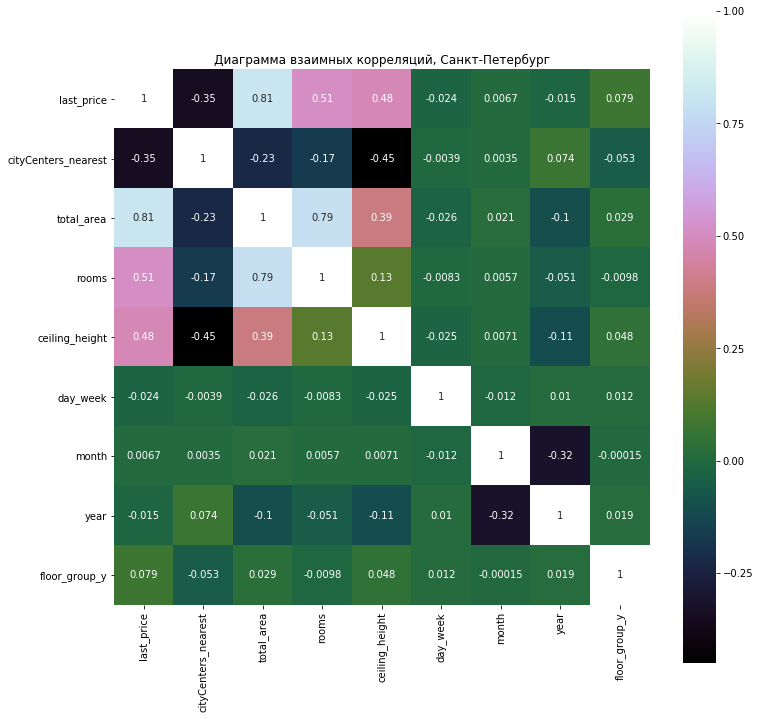

In [99]:
correlation_piter_all = data_piter_all.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_piter_all, vmax=1,
            square=True, annot=True, cmap='cubehelix')

plt.title('Диаграмма взаимных корреляций, Санкт-Петербург')
plt.show()  # просто захотелось попробывать потому что синтаксис простой.

- По сравнению с "центром города " появились более явные (хотя и слабые) зависимости цены от количества комнат, высоты потолков и расстояния до центра
- Цена квартиры еще больше стала зависить, от площади квартиры - коэф корреляции 0,81 - чем больше квартира, тем больше цена.   

Проверим все ли не Питерские объявления не имели записи о расстоянии до центра. Сильно ли влияют "не Санкт-Петербургские" объявления на корелляцию по "расстоянию до центра"

In [100]:
local_no_piter = data_estate['locality_name'] != 'Санкт-Петербург'
data_estate_temp = data_estate.query('@local_no_piter')
data_estate_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7914 entries, 1 to 23564
Data columns (total 29 columns):
total_images            7914 non-null int64
last_price              7914 non-null float64
total_area              7914 non-null float64
first_day_exposition    7914 non-null datetime64[ns]
rooms                   7914 non-null int64
ceiling_height          4385 non-null float64
floors_total            7914 non-null int64
living_area             7166 non-null float64
floor                   7914 non-null int64
is_apartment            927 non-null object
studio                  7914 non-null bool
open_plan               7914 non-null bool
kitchen_area            7035 non-null float64
balcony                 7914 non-null int64
locality_name           7914 non-null object
airports_nearest        2474 non-null float64
cityCenters_nearest     2473 non-null float64
parks_around3000        2474 non-null float64
parks_nearest           779 non-null float64
ponds_around3000        2474 no

Меньше 1/3 объявлений о продаже квартир не в Санкт_Петербурге имеют информация о расстоянии до центра (до какого центра?). Но это меньше 10% от всех записей. Поэтому и корреляция практически не меняется -0,35 и -0,36.

### Шаг 5. Общий вывод

## Исследовательский анализ данных:
###### Задание:
    Изучить следующие параметры: площадь, цена, число комнат, высота потолков. Построить гистограммы для каждого параметра. Убрать редкие и выбивающиеся значения. Описать, какие особенности обнаружили.  
       
Для выполнения этого задания каждый параметр изучался отдельно, строились гистограммы и диаграммы размаха для определения пороговых значений, данные проверялись на кол-во потерь от общего количества данных. Ограничение по общим допустимым потерям для каждого параметра приняли = 5% 

### Площадь квартиры
Данные по площади квартиры в объявлениях:
- Минимальные значения 12 кв.м. очень маленькие квартиры (комнаты скорее). 
- Среднее и медианные значения близки -  данные в основной массе без отклонений, тоже говорит и показатель 3 квартиля. 
- Есть явно сверхбольшие значения, судя по максимуму (900 кв.м.).

Анализ гистограмм по данным "площадь квартиры" по разным диапазонам значений для детального рассмотрения вариантов:
- Основная масса объявлений с площадью 30-100 кв.м. 
- Значительно меньше объявлений для квартир более 200 кв.м. (после 300 кв.м. - единичные случаи. 
- Для обработки задания подойдет область 25-140 кв.м. Проверили эту гипотезу через поиск пороговых значений

Пороговые значения по площади квартир через диаграммы размаха:
- Самые "маленькие квартиры" – те, что в районе 12 кв.м. 
- Объявления "выбросы" справа - "большая площадь"  начинаются с диапазона 120-140 кв.м.

По рассмотренным графикам и подсчетам доли данных по пороговым значениям определили:
- "Маленькие квартиры" - меньше 20 кв.м. = 0,11% от всех данных 
- «Большие квартиры» - более  130 кв.м. = 3,54% от вех данных.

#### Ограничения по данным "площадь квартиры" - 20-130 кв.м.

### Цена квартиры
Данные по стоимости квартиры в объявлениях:
- Очень низкое значение цены в минимальной части – 12 тыс. руб.. 
- Разница между средней (4,6 млн. руб.) и медианной (6,5 млн.руб.) ценой есть, но в пределах квартиля (2 млн.руб.), средняя цена больше - тоже влияние сверхбольших значений в "хвосте" данных 
- Максимальные значения – 763 млн.руб.

Анализ гистограмм по данным "цена квартиры" по разным диапазонам значений для детального рассмотрения вариантов:
- Разброс цен большой. 
- Объявления с ценой меньше 400 тыс. руб. явная аномалия, единичные экземпляры. 
- Реальные объявления начинаются с 400 тыс. руб. 
- Единичные случаи продажи квартир в диапазонах 400-600 тыс. руб. и 100-800 млн. руб. 
- Мало активности также в диапазоне 600 тыс. - 1 млн. руб. и 30-100 млн. руб. 

Пороговые значения по площади квартир через диаграммы размаха:
- Самые "дешевые" квартиры - минимальная стоимость около 12 тыс. руб.  
- «Выбросы» справа - "дорогие" квартиры начинаются с 12 млн. руб.

По рассмотренным графикам и по подсчетам доли данных пороговым значениям определили:
- "Дешевые" квартиры - меньше 1 млн. руб. = 0,95% от всех данных
- «Дорогие» - больше 15 млн. руб. = 5,07% от всех данных 

#### Ограничения по данным "цена квартиры" - 1-15 млн.руб.

### Количество комнат
Данные по количеству комнат в объявлениях:
- Минимальное значение комнат = 0
- Данные распределены нормально, среднее и медиана практически равны. 
- "Хвост" из большого количества комнат – 19 максимальное значение. 

Анализ гистограмм по данным "количество комнат" по разным диапазонам значений для детального рассмотрения вариантов:
- Основные продажи сосредоточены в значениях 1-4 комнаты. 
- Картиры студии и со свободной планировкой где пользователь указал "ноль" комнат 194 шт. - менее 1%. 
- Малый сегмент объявлений 5-7 комнат. 
- Единичные объявления где комнат более 8 (до 19  - одна такая). 
	
Пороговые значения по количеству комнат через диаграммы размаха:
- Минимальные значения соответствуют студиям и квартирам со свободной планировкой – там, где комнат условный "ноль". 
- Объявления "выбросы" справа - квартиры где комнат более 6.

По рассмотренным графикам определили и подсчетам доли данных по пороговым значениям:
- "Мало" комнат - меньше 1 = менее 1% от всех данных
- «Много» комнат - больше 6 = 0,38% от всех данных 

#### Ограничения по данным "количество комнат" - 1-6.

### Высота потолков
Данные по высоте потолков в объявлениях:
- Количество данных 2/3 от общего числа записей. 
- Есть явные "выбросы" - 1 метр (минимум) и 100 метров (максимум). 
- В общей массе данные плотно сгруппированы в районе реальных среднестатистических значений 2,5-3 м.

Анализ гистограмм по данным "высота потолков" по разным диапазонам значений для детального рассмотрения вариантов:
- Ограничили данные по высоте потолка диапазоном 2,5 до 3,5 метра. 
- Менее 1% квартир с потолками до 2,5 м. (хотя потолки 2,4 - вполне объективная реальность) и с потолками высотой более 4,2 метра. 
- Высота потолков более 10 метров для квартир - явная «аномалия» .

Пороговые значения по высоте потолков через диаграммы размаха:
- Минимальное значение порога - 2,2 м. 
- Объявления "выбросы" справа - квартиры с потолками более 3,3 м. 

По рассмотренным графикам и по подсчетам доли данных по пороговым значениям определили:
- Квартиры с "низкими" потолками  < 2,2 м. = 0,06% от всех данных 
- "Высокие" потолки > 3,3 м. = 2,57% от всех данных

#### Ограничения по данным "высота потолков" – 2,2 – 3,3 метра.

##### Задание
    - Изучить время продажи квартиры. Построить гистограмму. Посчитайте среднее и медиану. Описать, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго? Убрать редкие и выбивающиеся значения. Описать, какие особенности обнаружили
    
### Время продажи квартиры
Данные по кол-ву дней публикации в объявлениях:
- Минимально объявление продержалось 1 день
- Максимально более 4 лет. 
- Основной массив объявлений расположен в районе 50-200 дней срока публикации. 
- Стандартное отклонение (219) немногим больше среднего (180) и сравнимо со значением третьего квартиля (231). 
- Предыдущий пункт и разница между максимумом и третьим квартилем подтверждает что есть "длинный хвост" из небольшого количества "длинных объявлений" более года.

Анализ гистограмм по данным "время продажи квартиры" по разным диапазонам значений для детального рассмотрения вариантов:
- Количество объявлений более 100 начинаются примерно с 3 дней с момента публикации 
- После 600-700 дней количество объявлений заметно падает (менее 50 дней)

Пороговые значения по высоте потолков через диаграммы размаха:
- Самые короткие объявления - те что продержались меньше одного дня.
- Объявления - "выбросы" с большим сроком публикации начинаются примерно с 520 дней.
   
По рассмотренным графикам и по подсчетам доли данных по пороговым значениям определили:
- "Короткие" объявления -  меньше 3 дней. = 0,02% от всех данных
- «Длинные» -  более 600 дней =  5.06%. от всех данных

#### Быстрая продажа это меньше 3 дней, а самые длинные объявления - со сроком более 600 дней с момента старта продаж.

##### Задание
    - Определить факторы больше всего влияющие на стоимость квартиры? Изучить, зависит ли цена от квадратного метра, числа комнат, удалённости от центра. Изучить зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучить зависимость от даты размещения: дня недели, месяца и года.
    
### Какие факторы больше всего влияют на стоимость квартиры?   
   
Массив данных под конкретную задачу, с условием ограничений сверху и снизу выявленных нами ранее «потерял» 7,72% данных, но потери явно из-за обрезанных "хвостов" по максимальным значениям данных. Взаимное влияние параметров проверяли с помощью функции корреляции

Таблица и график ("тепловая карта") взаимных корреляций выявили следующие закономерности:
- Цена квартиры НЕ ЗАВИСИТ от даты размещения объявления - коэф. корреляции равен практически 0   
- СИЛЬНАЯ зависимость, но не линейная, от площади квартиры – коэф. корреляции более 0,7 - чем больше квартира, тем больше цена. 
- Слабая зависимость от количества комнат (0,46) и удаленности от центра (-0,36), причем чем ближе к центру, тем стоимость квартир больше.
- Зависимость цены квартиры от этажа (в категориях "первый, последний, другой") отсутствует.

Последнее утверждение проверили через медиану и среднее значение цены квартиры по отношению к этажности -  и средние и медианные значения слабо изменились в зависимости от этажности.

##### Задание
    Выбрать 10 населённых пунктов с наибольшим числом объявлений. Посчитать среднюю цену квадратного метра в этих населённых пунктах. Выделить населённые пункты с самой высокой и низкой стоимостью жилья.
    
Данные для расчетов подготовили с учетом ограничений принятых ранее по стоимости квартир.    
По данным из таблицы «TOП 10 населенных пунктов где больше всего объявлений,
с данными по среднему значению стоимости за кв.м. и максимальной и минимальной ценой квартиры»: 
- В ТОП 10 вошли: Санкт-Петербург, поселок Мурино, поселок Шушары, Всеволожск, Пушкин, Колпино, поселок Парголово, Гатчина, деревня Кудрово, Выборг
- Больше всего объявлений, ожидаемо, в Санкт-Петербурге. 
- Тут же самая высокая цена за кв. метр (~ 107 тыс. руб.) и самая высокая максимальная цена (до предельных 15 млн. руб.). 
- Максимальные цены почти везде больше 10 млн. руб. 
- Минимальные цены в диапазоне 1-2 млн.руб.
- Самая минимальная цена в городах Гатчина и Выборг - 1,05 млн.руб.

##### Задание
    Изучить предложения квартир Санкт-Петербурге. Выяснить, какая область входит в центр. Создать столбец с расстоянием 
    до центра в километрах: округлить до целых значений. Посчитать среднюю цену для каждого километра. Построить график: 
    как цена зависит от удалённости от центра. Определить границу, где график сильно меняется — это и есть центральная зона.

Данные для расчетов подготовили с учетом ограничений принятых ранее по стоимости квартир.    
Ограничили базу объявлениями по Санкт-Петербургу    
По графику зависимости средней цены квартиры от расстояния до центра заметное падение цены начинается после радиуса 5 км. от центра. Два пика в районе 20 км. и в районе 27 км. Возможно это радиус пригорода с элитными районами.    
##### Радиус объявлений из центра города ограничили 5 км.

##### Задание
    - По сегменту квартир в центре проанализировать следующие параметры: площадь, цена, число комнат, высота потолков. 
    Выделить факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, 
    дата размещения объявления). Сделать выводы. Сравнить с общими выводами по всему городу
Данные подготовили с учетом ограничений:
- только центр - до 5 км радиус расположения квартир
- только Санкт-Петербург
- другие ограничения выделенные ранее по цене, высоте потолков и т.д.

Таблица и график ("тепловая карта") взаимных корреляций выявили следующие закономерности:
- Цена квартиры НЕ ЗАВИСИТ (коэф. корреляции равен практически равен 0) от:
    - высоты потолков
    - даты размещения объявления
    - этажности
    - удаленности от центра (она и так в центре)
- Цена квартиры ЗАВИСИТ, от площади квартиры - коэф корреляции 0,65 - чем больше квартира, тем больше цена.   
- Слабая зависимость от количества комнат в квартире (0,38).

По сравнению с ситуацией, когда мы рассматривали всю базу – «Санкт-Петербург и пригороды» есть различия:
- Зависимость цены квартиры от площади была выше - 0,74
- Зависимость от количества комнат была больше 0,46 (несущественно)
- Зависимость от удаленности от центра была ощутимо выше -0,36, по сравнению с показателями по центру Санкт-Петербурга, что естественно, ведь данные ограничили радиусом "центра "Санкт-Петербурга" т.е. фактически исключили этот параметр из анализа.

Проверили базу по Санкт-Петербургу, без ограничения  - "центр города"     
Таблицу и график ("тепловая карта") взаимных корреляций выявили следующие закономерности:
- По сравнению с "центром города " появились более явные (хотя и слабые) зависимости цены от количества комнат, высоты потолков и расстояния до центра
- Цена квартиры еще больше стала зависеть, от площади квартиры - коэф корреляции 0,81 (увеличился).   
- Проверили, все ли не городские объявления не имели записи о расстоянии до центра. Сильно ли влияют такие объявления на корелляцию по "расстоянию до центра". Меньше 1/3 объявлений о продаже квартир не в Санкт-Петербурге имеют информация о расстоянии до центра. Но это меньше 10% от всех записей. Поэтому и корреляция практически не меняется -0,35 и -0,36.

##### Баг–репорт:
- В базе объявлений есть отсутствующие картографические данные, получаемые автоматически через систему – нужно проверять на каком этапе эти значения теряются или не проставляются вовсе. 
- В базе объявлений есть отсутствующие данные по срокам  размещения объявления – нужно проверять действующие ли это объявления (квартира еще не продана), или это ошибка пользователя,  или это системный сбой закрытия. 
